# Building EO training/validation/testing datasets with the Sentinelhub API

#### The following modules/Libraries will be needed

In [1]:
from sentinelhub import BBox, CRS, DataCollection, SHConfig, WmsRequest, WcsRequest, DataSource, MimeType
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
import rasterio
import numpy as np
import datetime

import os 
from osgeo import gdal
import glob

import imageio

from PIL import Image
import io

from rasterio.transform import from_bounds

import rasterio
from matplotlib import pyplot
from rasterio.plot import show

import numpy as np
import os 

### Prerequisites

#### Sentinel Hub account

In order to use Sentinel Hub services you will need a Sentinel Hub account. If you do not have one yet, you can create a free trial account at [Sentinel Hub webpage](https://services.sentinel-hub.com/oauth/subscription). If you are a researcher you can even apply for a free non-commercial account at [ESA OSEO page](https://earth.esa.int/aos/OSEO).

Once you have the account set up, login to [Sentinel Hub Configurator](https://apps.sentinel-hub.com/configurator/). Inside there will already exist one configuration with an **instance ID** (alpha-numeric code of length 36). For this tutorial it is recommended that you create a new configuration (`"Add new configuration"`) and set the configuration to be based on **Python scripts template**. Such configuration will already contain all layers used in these examples. Otherwise you will have to define the layers for your  configuration yourself.

After you have decided which configuration to use, you have two options. You can either put configuration's **instance ID** into `sentinelhub` package's configuration file following the [configuration instructions](http://sentinelhub-py.readthedocs.io/en/latest/configure.html) or you can write it down in the following cell:

Generate a configuration:
This is done using the ID.
This is so that sentinelhub knows you are authorised to use their service, and which parts of the service you want to use.

In [ ]:
INSTANCE_ID = '432b0edf-79be-4d35-99b5-ac3414ba9b4f'
if INSTANCE_ID:
    config = SHConfig()
    config.instance_id = INSTANCE_ID
else:
    config = None

print(config)

If you just wanted to download a true colour composite, you could use WcsRequest()
If you want to access the full Sentinel-2 product (with all channels) you can use wms request.
We can  then use band 2 and band 11 (SWIR and Blue) to create a normalised difference snow index (NDSI) and the normalised difference water index

Define a region and a random test date 

In [ ]:
class SentinelData:
    """
    Retreiveing Sentinel data from Sentinel Hub
    initialise class with coordinates list, resolution, bounding box coordinates, years and month ranges
    make a wcs request for data between November-April
    """
    def __init__(self, coords_list, years, day_month_to, day_month_from):
        self.coords_list = coords_list
        self.resolution = '10m'
        self.area_coords = BBox(bbox=self.coords_list, crs=CRS.WGS84)
        self.year_range = years # make a set of years to iterate over 
        self.day_month_to = day_month_to
        self.day_month_from = day_month_from
        
        
        
    def retrieve_data(self):
        """ 
        Create a bounding box and assign CRS. 
        Create a wcs data request from Sentinel for Sentinel-2 data. 
        Define max clouds as 20%
        """
        for year in self.year_range:
            time_from = "{}-{}".format(year, self.day_month_from)
            print("time_from", time_from)
            time_to = "{}-{}".format(year + 1,  self.day_month_to)
            print("time_to", time_to)
            # make the request for the desired date range 
            wcs_true_color_request = WcsRequest (
                data_collection=DataCollection.SENTINEL2_L1C,
                layer='TRUE-COLOR-S2-L2A', # Layer you have configured
                bbox=self.area_coords,
                time= (time_from, time_to),
                resx=self.resolution, # Stick to 10m resolution as this the maximum possible 
                resy=self.resolution, 
                config=config,
                maxcc=0 # You can define the maximum ammount of cloud coverage you want to allow. 
            )
            print("WCS: ", wcs_true_color_request)
    
            available_dates_list = wcs_true_color_request.get_dates()
            print("avail dates list: ", available_dates_list)
            yield from available_dates_list
            
    
    def get_available_data(self):
        """
        Use get_data() function from Sentinel to retrieve available data for the dates.
        """
        available_dates_list = self.retrieve_data()
        i = 0
        for date in available_dates_list:
            i += 1
            print("date", date)
            
            wcs_true_color_request = WcsRequest(
                data_collection=DataCollection.SENTINEL2_L1C,
                layer='TRUE-COLOR-S2-L2A', # Layer you have configured
                bbox=self.area_coords, 
                time= date,
                resx=self.resolution, # Stick to 10m resolution as this the maximum possible 
                resy=self.resolution, 
                config=config,
                maxcc=0,# You can define the maximum ammount of cloud coverage you want to allow.
                data_folder='/Users/emilybirch/Documents/UCL_Dissertation' 
            )
            
            basemap = wcs_true_color_request.get_data()[0] 
            
            # call the bands_req function to wms request for bands on available dates
            call_wms = self.bands_req(basemap, date, i) # basemap,
            
            print('Returned data is of type = %s and length %d.' % (type(basemap), len(basemap)))
            print(f'Single element in the list is of type {type(basemap[-1])} and has shape {basemap[-1].shape}')
           
            
            

            
    def bands_req(self, basemap, date, i):
        """
        wms bands request for the bands making up the Sentinel pic
        """
       # for basemap in self.get_available_wms_data():
        basemap = np.array(basemap)
        wms_bands_request = WmsRequest(
            data_collection=DataCollection.SENTINEL2_L1C,
            layer='BANDS-S2-L2A', # We are using the 'BANDS-S2-L2A layer now'
            bbox= self.area_coords, # [50.19571, -124.25775, 49.98687, -123.90537], 
            width=basemap.shape[1], # 10m resolution dims are sourced from the basemap. 
            height=basemap.shape[0],
            time=(date),
            image_format=MimeType.TIFF, 
            maxcc=0,
            #resx='10m',
           # resy = '10',
            config=config,
            data_folder='/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/WMS_all_bands' 
        )        
        
        bands = wms_bands_request.get_data()[-1] # save_data=True
        bands = np.array(bands)
        bands = bands.astype('float32') 
           
        # call the split_bands function
        get_channels = self.split_bands(bands, basemap, i)

 
 
# Four coordinates representing the top-left and bottom-right of the bounding box must be separated by comma
# The bounding box in WGS84 coordinate system is (longitude and latitude coordinates of upper left and lower right corners)
# n,w, s,e

 #a list of comma-separated numbers of the form "minx,miny,maxx,maxy".       
 # s2, w2 = 49.98434, -124.25091 w,s,n,e
#n2, e2 = 50.19579, -123.90758   

# wms should be latitude, long


    
    def plot_data(self):   
        """
        Plot the RGB satellite pics to check its correct/cloud cover is acceptable
        and that the image is not cropped.
        """
        basemap = self.get_available_data()
        i = 0
        for sat_img in basemap:
            i += 1
            print("i", i)
            fig, ax = plt.subplots(1, 1, figsize=(10,10))
            plt.imshow(sat_img)
            plt.axis('off')
            plt.savefig('ala_sat_4_{}.png'.format(i),
                        bbox_inches='tight',
                        dpi=300)
            plt.show()
          

 
       
        
    # Download NIR (b08), DEM and Raw NDSI (no thresholding)          
    def split_bands(self, bands, basemap, i):
        """
        Split the bands req into individual bands
        Download NIR b08 as single band .tif
        Calculate NDSI and download this as .tif
        """
        #bands = self.get_available_wms_data()
            
        b01 = bands[:,:,0] # Coastal Aerosol
        b02 = bands[:,:,1] # Blue
        b03 = bands[:,:,2] # Green
        b04 = bands[:,:,3] # Red
        b05 = bands[:,:,4] # Vegetation Red Edge 
        b06 = bands[:,:,5] # Vegetation Red Edge
        b07 = bands[:,:,6] # Vegetation Red Edge
        b08 = bands[:,:,7] # NIR
        b08a = bands[:,:,8] # Vegetation Red Edge
        b09 = bands[:,:,9] # Water Vapour
        b11 = bands[:,:,10] # SWIR
        b12 = bands[:,:,11] # SWIR
        
        
        # check b08 is array
        print("TYPE OF B08:",(type(b08)))
 
        # get NIR band as .tif
        raster = b08
        dim = raster.shape
        print(dim)
        height = dim[0] 
        print("height", height)
        width = dim[1] 
        print("width", width)
       # transform - NEEDS TO BE W,S,E,N. CURRENTLY THE BBOX COORDS ARE S,W,N,E. SO NEED TO SWITCH TO 116,50 NOT 50,116
        transform=from_bounds(168.67527, -44.64093, 168.99039, -44.42578, width, height)  # self.coords_list
        print("TRANSFORM:", transform)
        os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/NIR')
        out_path = ('b08_nz_bbox1_{}.tif'.format(i)) 
        print("OUT PATH", out_path)

        write_NIR_band = write_single_channel_gtiff(raster, width, height, transform, out_path)  # self. ?
        print(write_NIR_band)

        ###########
        # calc NDSI from bands
        NDSI = (b03 - b11)/(b03 + b11)
        raster = NDSI
        dim = raster.shape
        print(dim)
        height = dim[0] 
        print("height", height)
        width = dim[1] 
        print("width", width)
       # transform - NEEDS TO BE W,S,E,N. CURRENTLY THE BBOX COORDS ARE S,W,N,E. SO NEED TO SWITCH TO 116,50 NOT 50,116
        transform=from_bounds(168.67527, -44.64093, 168.99039, -44.42578, width, height)  # self.coords_list
        print("TRANSFORM:", transform)
        os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/NDSI')
        out_path = ('NDSI_nz_bbox1_{}.tif'.format(i)) 
        print("OUT PATH", out_path)

        write_NDSI_band = write_single_channel_gtiff(raster, width, height, transform, out_path)  # self. ?
        print(write_NDSI_band)

        

# W,S,E,N. SO NEED TO SWITCH TO 116,50

# can box1- -116.08768, 50.82675, -115.73474,51.02583 
# canbb0x 2. -123.27264, 49.60259, -122.94511, 49.80043. b08_can_bbox2_{}.tif
# can box3. -124.25091, 49.98434, -123.90758, 50.19579. b08_can_bbox3_{}.tif

# france box1. 6.68625, 46.00263, 7.00556, 46.21018. b08_fr_bbox1_{}.tif
# fr box2. 6.26995, 44.5032, 6.57683, 44.71395. b08_fr_bbox2_{}.tif
# fr box3. 6.75874, 47.89925, 7.0709, 48.0968. b08_fr_bbox3_{}.tif

# Nz box1. 168.67527, -44.64093, 168.99039, -44.42578. b08_nz_bbox1_{}.tif
# nz box 2. 169.15172, -44.46215, 169.4559,-44.26874. b08_nz_bbox2_{}.tif
# nz box 3. 167.32814, -45.57742, 167.63988, -45.37906. b08_nz_bbox3_{}.tif
# nz box 4. 168.7185, -44.21029, 169.00415, -43.99234. b08_nz_bbox4_{}.tif

# norway box1. 6.71053, 61.19427, 7.14765, 61.39842. b08_nor_bbox1_{}.tif
# nor box2. 11.91172, 62.11413, 12.35366, 62.31454. b08_nor_bbox2_{}.tif
# nor box3. 11.68324, 64.5321, 12.17067, 64.72623. b08_nor_bbox3_{}.tif

# argentina box1. -70.60757, -36.1615, -70.87261, -36.35363. b08_arg_bbox1_{}.tif
# arg box2. -71.07906, -36.90052,-70.80853, -36.7103. b08_arg_bbox2_{}.tif
# arg box3. -72.33129, -48.25276, -72.0168, -48.05762. b08_arg_bbox3_{}.tif

# alaska box1. -144.4895, 60.58666, -144.04753, 60.78174. b08_al_bbox1_{}.tif
# al box2. -145.6761, 60.54723, -145.24079, 60.74312. b08_al_bbox2_{}.tif
# al box 3. -146.57959, 60.86118, -146.14288, 61.05052. b08_al_bbox3_{}.tif
# al box 4. -146.62525, 61.10963, -146.18168, 61.30145. b08_al_bbox4_{}.tif


def write_single_channel_gtiff(raster, width, height, transform, out_path): 
    """
    Function to write a single channel .tif file. 
    Retains the geographic info- extent, crs etc. 
    """
    assert len(raster.shape) == 2
    print(f'Writing...{out_path}')
    with rasterio.open(str(out_path),
                       mode='w',
                       crs= 'EPSG:4326',   # wgs84         
                       driver= 'GTIFF',                
                       nodata=  np.nan,
                       dtype= rasterio.float32,   # raster.dtype   #  rasterio.uint8,               
                       count= 1,                 
                       height= height,         
                       width= width,     
                       # compress='lzw'
                       transform=transform # w2, s2, e2, n2, width, height. From bbox
                       ) as dst:
        dst.write(raster, 1) #.astype(np.uint8)
        


# call
# define the years and month ranges for data. Nov-April so there is snow cover.
# Sentinel 2 data is only available from 2015 onwards
canada_years = {2014, 2015, 2016, 2017, 2018, 2019, 2020}

# define the years and month ranges for data. Nov-April
canada_day_month_to = "01-01"
canada_day_month_from = "01-01"

# canada 0%CC. BBOX1. CANADIAN ROCKIES
s4, w4 = 50.82675, -116.08768
n4, e4 = 51.02583, -115.73474       


# CANADA BBOX2 0%CC. VANCOUVER. takes a long time to plot (90 plots)
s5, w5 = 49.60259, -123.27264
n5, e5 = 49.80043, -122.94511
    

# canada BBOX3. nr vancouver 
s6, w6 = 49.98434, -124.25091
n6, e6 = 50.19579, -123.90758
       
    
coords_canada1 = [w4, s4, e4, n4]
coords_canada2 = [w5, s5, e5, n5]
coords_canada3 = [w6, s6, e6, n6]

can_data1 = SentinelData(coords_canada1, canada_years, canada_day_month_to, canada_day_month_from)
can_data2 = SentinelData(coords_canada2, canada_years, canada_day_month_to, canada_day_month_from)
can_data3 = SentinelData(coords_canada3, canada_years, canada_day_month_to, canada_day_month_from)

# wcs 
#plot_data_1 = canada_data.plot_data()


# get wms
#plot_canada_wms1 = can_data1.get_available_data()
#plot_canada_wms2 = can_data2.get_available_data()
#plot_canada_wms3 = can_data3.get_available_data() 
    
  
 
# FORESTED:

# 1. 

# FRANCE BBOX 1. 0%CC
s, w = 46.00263, 6.68625
n, e = 46.21018, 7.00556


# FRANCE BBOX 2. 0%CC
s2, w2 = 44.5032, 6.26995
n2, e2 = 44.71395, 6.57683

# FRANCE BBOX 3. 0%CC. in Vosges mountains. 
s3, w3 = 47.89925, 6.75874
n3, e3 = 48.0968, 7.0709
    
coords_fr1 = [w, s, e, n]
coords_fr2 = [w2, s2, e2, n2]
coords_fr3 = [w3, s3, e3, n3]

fr_data1 = SentinelData(coords_fr1, canada_years, canada_day_month_to, canada_day_month_from)
fr_data2 = SentinelData(coords_fr2, canada_years, canada_day_month_to, canada_day_month_from)
fr_data3 = SentinelData(coords_fr3, canada_years, canada_day_month_to, canada_day_month_from)


# get wms
#plot_fr_wms1 = fr_data1.get_available_data()
#plot_fr_wms2 = fr_data2.get_available_data()
#plot_fr_wms3 = fr_data3.get_available_data()


# NEW ZEALAND 0% CC. BBOX1. FORESTED. gets 3 3/4 pics 
s7, w7 = -44.64093, 168.67527
n7,e7 = -44.42578, 168.99039


# NZ BBOX 2 FORESTED. 3 pics  
s8,w8 = -44.46215, 169.15172
n8,e8 = -44.26874, 169.4559


# NZ BBOX 3. 3 pics 
s9,w9 = -45.57742, 167.32814
n9,e9 = -45.37906, 167.63988


# NZ bbox 4. 
s10,w10 = -44.21029, 168.7185
n10, e10 = -43.99234, 169.00415
    


coords_nz1 = [w7, s7, e7, n7]
coords_nz2 = [w8, s8, e8, n8]
coords_nz3 = [w9, s9, e9, n9]
coords_nz4 = [w10, s10, e10, n10]


nz_data1 = SentinelData(coords_nz1, canada_years, canada_day_month_to, canada_day_month_from)
nz_data2 = SentinelData(coords_nz2, canada_years, canada_day_month_to, canada_day_month_from)
nz_data3 = SentinelData(coords_nz3, canada_years, canada_day_month_to, canada_day_month_from)
nz_data4 = SentinelData(coords_nz4, canada_years, canada_day_month_to, canada_day_month_from)


# get wms
#plot_nz_wms1 = nz_data1.get_available_data()
#plot_nz_wms2 = nz_data2.get_available_data()
#plot_nz_wms3 = nz_data3.get_available_data()
#plot_nz_wms4 = nz_data4.get_available_data()
        

    
    # NON-FORESTED:  


# 4. 



# Norway. scandy mountains. 
s11, w11 = 61.19427, 6.71053
n11, e11 = 61.39842, 7.14765
  

# BBOX 2 
s12, w12 = 62.11413, 11.91172
n12, e12 = 62.31454, 12.35366


# BBOX 3. nr namsos
s13, w13 = 64.5321, 11.68324
n13, e13 = 64.72623, 12.17067



coords_nor1 = [w11, s11, e11, n11]
coords_nor2 = [w12, s12, e12, n12]
coords_nor3 = [w13, s13, e13, n13]

nor_data1 = SentinelData(coords_nor1, canada_years, canada_day_month_to, canada_day_month_from)
nor_data2 = SentinelData(coords_nor2, canada_years, canada_day_month_to, canada_day_month_from)
nor_data3 = SentinelData(coords_nor3, canada_years, canada_day_month_to, canada_day_month_from)


# get wms
#plot_nor_wms1 = nor_data1.get_available_data()
#plot_nor_wms2 = nor_data2.get_available_data()
#plot_nor_wms3 = nor_data3.get_available_data()

# 5. 


# Argentina. bbox 1. 
s14, w14 = -36.1615, -70.60757
n14, e14 = -36.35363, -70.87261
    

# Argentina BBOX2
s15, w15 = -36.90052, -71.07906
n15, e15 = -36.7103, -70.80853
    
   
 # Argentina BBOX3
s16, w16 = -48.25276, -72.33129
n16, e16 = -48.05762, -72.0168
       
coords_arg1 = [w14, s14, e14, n14]
coords_arg2 = [w15, s15, e15, n15]
coords_arg3 = [w16, s16, e16, n16]

arg_data1 = SentinelData(coords_arg1, canada_years, canada_day_month_to, canada_day_month_from)
arg_data2 = SentinelData(coords_arg2, canada_years, canada_day_month_to, canada_day_month_from)
arg_data3 = SentinelData(coords_arg3, canada_years, canada_day_month_to, canada_day_month_from)


# get wms
plot_arg_wms1 = arg_data1.get_available_data()
#plot_arg_wms2 = arg_data2.get_available_data()
# plot_arg_wms3 = arg_data3.get_available_data()
  

 
# 6. 

 # Alaska bbox1 3 pics
s17, w17 = 60.58666, -144.4895
n17, e17 = 60.78174, -144.04753
    
    
    
# alaska bbox 2 2 pics
s18, w18 = 60.54723, -145.6761
n18, e18 = 60.74312, -145.24079
    

    
# alaska bbox 3. 3 pics
s19, w19 = 60.86118, -146.57959
n19, e19 = 61.05052, -146.14288


# alaska bbox 4. 3 pics 
s20, w20 = 61.10963, -146.62525
n20, e20 = 61.30145, -146.18168


coords_al1 = [w17, s17, e17, n17]
coords_al2 = [w18, s18, e18, n18]
coords_al3 = [w19, s19, e19, n19]
coords_al4 = [w20, s20, e20, n20]


al_data1 = SentinelData(coords_al1, canada_years, canada_day_month_to, canada_day_month_from)
al_data2 = SentinelData(coords_al2, canada_years, canada_day_month_to, canada_day_month_from)
al_data3 = SentinelData(coords_al3, canada_years, canada_day_month_to, canada_day_month_from)
al_data4 = SentinelData(coords_al4, canada_years, canada_day_month_to, canada_day_month_from)


# get wms
#plot_al_wms1 = al_data1.get_available_data()
#plot_al_wms2 = al_data2.get_available_data()
#plot_al_wms3 = al_data3.get_available_data()
#plot_al_wms4 = al_data4.get_available_data()

In [125]:
# find the min and max across all files so i can normalise to this

import imageio
import os
import rasterio as rio

path = os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/normalised_bands/old/NIR')
files = os.listdir(path)
print("files", files)

min_max = {'nNIR':[1000000,0]}

for fname in files:
    print("fname:", fname)
    # print/ find min max across all files
    with rio.open(fname) as nNIR_file:
        nir_tiff = nNIR_file.read()
        # print("nir tiff", nir_tiff)
        # GET MIN MAX of each img
        nir_mm = (np.amin(nir_tiff), np.amax(nir_tiff))
       # print("nir mm", nir_mm) # print min and max of ALL nir files 
       # print('orig nir min[0] is', nir_mm[0])

        #  if observed min is smaller than current min, update with new min
        #  if observed max is bigger than current max, update with new max
        if nir_mm[0] <= min_max['nNIR'][0]: # if the min is less than 0, then make it 0
            min_max['nNIR'][0] = nir_mm[0]
           # print('min max NIR is: ',min_max)
        if nir_mm[1] >= min_max['nNIR'][1]: # if the max is more than 1000000 then make 
            min_max['nNIR'][1] = nir_mm[1]
           # print('min max NIR is: ',min_max)
        # track progress through loop
    print(min_max)

files ['b08_nz_bbox2_4.tif', 'b08_nz_bbox2_5.tif', 'b08_arg_bbox1_8.tif', 'b08_nz_bbox4_3.tif', 'b08_fr_bbox2_4.tif', 'b08_nz_bbox2_3.tif', 'b08_fr_bbox2_6.tif', 'b08_nz_bbox1_6.tif', 'b08_nor_bbox3_14.tif', 'b08_can_bbox1_2.tif', 'b08_fr_bbox1_2.tif', 'b08_nz_bbox4_10.tif', 'b08_nor_bbox3_15.tif', 'b08_can_bbox3_1.tif', 'b08_can_bbox3_3.tif', 'b08_can_bbox1_1.tif', 'b08_nz_bbox4_13.tif', 'b08_can_bbox3_2.tif', 'b08_nz_bbox3_6.tif', 'b08_nz_bbox3_2.tif', 'b08_can_bbox1_4.tif', 'b08_fr_bbox1_5.tif', 'b08_can_bbox1_5.tif', 'b08_nz_bbox3_3.tif', 'b08_fr_bbox3_25.tif', 'b08_nor_bbox1_14.tif', 'b08_can_bbox3_5.tif', 'b08_fr_bbox1_7.tif', 'b08_can_bbox3_4.tif', 'b08_nor_bbox1_15.tif', 'b08_fr_bbox3_18.tif', 'b08_nor_bbox2_3.tif', 'b08_can_bbox2_83.tif', 'b08_nor_bbox1_18.tif', 'b08_fr_bbox3_15.tif', 'b08_arg_bbox2_2.tif', 'b08_can_bbox2_82.tif', 'b08_al_bbox4_2.tif', 'b08_arg_bbox2_1.tif', 'b08_fr_bbox1_8.tif', 'b08_fr_bbox3_17.tif', 'b08_nor_bbox2_1.tif', 'b08_nor_bbox2_5.tif', 'b08_nor_bbo

In [131]:
# find min and max of bands first

# NIR BAND FIRST!!!!!


import imageio
import os
import rasterio as rio

path = os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Final_files/Non_scaled_final_bands/NIR_to_rescale')
files = os.listdir(path)
print("files", files)


#def rescale_tif():
#    """
#    find the min and max values of ALL tif files in dir.
#    rescale (normalise) the tif to between 0-255
  
#    """ 

min_max = {'nNIR':[1000000,0]}


for fname in files:
    os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Final_files/Non_scaled_final_bands/NIR_to_rescale')

    # OPEN FROM A TIFF FILE
    with rio.open(fname) as nNIR_file:  # files[0]
        print("f", fname)
        # get metadata to write tif later
        meta = nNIR_file.meta
        print("META:",meta)
        width = nNIR_file.width
        print("w", width)
        height = nNIR_file.height
        print("height", height)
        transform = nNIR_file.transform
        print("TRANSFORM:", transform)

        # read as array
        nir_tiff = nNIR_file.read()
       # print("nir tiff", nir_tiff)
        # GET MIN MAX of each img
        nir_mm = (np.amin(nir_tiff), np.amax(nir_tiff))
       # print("nir mm", nir_mm) # print min and max of ALL nir files 
       # print('orig nir min[0] is', nir_mm[0])

        #  if observed min is smaller than current min, update with new min
        #  if observed max is bigger than current max, update with new max
        if nir_mm[0] <= min_max['nNIR'][0]: # if the min is less than 0, then make it 0
            min_max['nNIR'][0] = nir_mm[0]
       #     print('min max NIR is: ',min_max)
        if nir_mm[1] >= min_max['nNIR'][1]: # if the max is more than 1000000 then make 
            min_max['nNIR'][1] = nir_mm[1]
        #    print('min max NIR is: ',min_max)
        # track progress through loop
        print(min_max)
        
        # nir min and max are:
        # {'nNIR': [0.0, 1.6144]}
        for pixel_value in nir_tiff:
            #print("original pixel values", pixel_value)
            # rescale each pixel between 0-255
            # dividing all pixels values by the largest pixel value to get 0-1 then * 255
            rescaled_nir = ((pixel_value - 0.0)/(1.6144 - 0.0)) * 255
            #rescaled_nir = (pixel_value/1.6144) * 255
            # print('Min: %.3f, Max: %.3f' % (rescaled_nir.min(), rescaled_nir.max()))
            print("rescaled_nir array values:", rescaled_nir)

        # set out dir
        os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Final_files/Normalised_bands/NIR_normalised') 
        out_path = fname
        # (fname + '___{}.tif'.format(i))
        print("out_path", out_path)
        # call func to write the tif 
        write_tif_band = write_single_channel_gtiff(rescaled_nir, width, height, transform, out_path)  # self. ?
        #print(write_tif_band)
        #os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/normalised_bands/old/NIR')
        




def write_single_channel_gtiff(raster, width, height, transform, out_path): 
    """
    Function to write a single channel .tif file. 
    Retains the geographic info- extent, crs etc. 
    """
    assert len(raster.shape) == 2
    print(f'Writing...{out_path}')
    with rasterio.open(str(out_path),
                       mode='w',
                       crs= 'EPSG:4326',   
                       driver= 'GTIFF',            
                       # Be careful not to specify a no data value that is also valid within the dataset.
                       nodata= np.mean(raster), # 0,  # np.nan, 256? but setting this makes the file a higher bit
                       dtype= raster.dtype,   #  rasterio.float32              
                       count= 1,                 
                       height= height,         
                       width= width,     
                       transform= transform 
                       ) as dst:
        dst.write(raster, 1) #.astype(np.uint8)
        
        


files ['float_b08_arg_bbox1_2.tif', 'b08_fr_bbox2_2.tif', 'float_b08_arg_bbox3_3.tif', 'float_b08_arg_bbox1_1.tif', 'b08_nz_bbox2_4.tif', 'b08_nz_bbox2_5.tif', 'b08_nz_bbox4_3.tif', 'b08_fr_bbox2_4.tif', 'float_b08_arg_bbox1_5.tif', 'float_b08_arg_bbox3_5.tif', 'float_b08_arg_bbox1_7.tif', 'b08_nz_bbox2_3.tif', 'b08_fr_bbox2_6.tif', 'float_b08_arg_bbox3_4.tif', 'b08_nz_bbox1_6.tif', 'b08_nor_bbox3_14.tif', 'b08_can_bbox1_2.tif', 'b08_fr_bbox1_2.tif', 'float_b08_arg_bbox2_2.tif', 'b08_nz_bbox4_10.tif', 'b08_nor_bbox3_15.tif', 'b08_can_bbox3_1.tif', 'b08_can_bbox3_3.tif', 'b08_can_bbox1_1.tif', 'float_b08_arg_bbox2_1.tif', 'b08_nz_bbox4_13.tif', 'b08_can_bbox3_2.tif', 'b08_nz_bbox3_6.tif', 'b08_nz_bbox3_2.tif', 'b08_can_bbox1_4.tif', 'b08_fr_bbox1_5.tif', 'b08_can_bbox1_5.tif', 'b08_nz_bbox3_3.tif', 'b08_fr_bbox3_25.tif', 'b08_nor_bbox1_14.tif', 'b08_can_bbox3_5.tif', 'float_b08_arg_bbox2_7.tif', 'b08_fr_bbox1_7.tif', 'b08_can_bbox3_4.tif', 'b08_nor_bbox1_15.tif', 'b08_fr_bbox3_18.tif', 

{'nNIR': [0.0, 1.5776]}
rescaled_nir array values: [[35.855427 37.02428  38.414272 ... 33.833626 31.085232 29.537289]
 [34.528618 35.507927 37.150646 ... 33.138626 31.211596 29.663652]
 [34.71816  35.571106 36.424057 ... 33.233402 32.696358 31.116823]
 ...
 [34.30748  33.70726  36.139744 ... 25.841179 25.841179 25.87277 ]
 [31.748638 27.547075 28.21048  ... 25.683224 26.062315 26.220266]
 [30.642963 25.114594 22.20825  ... 25.493681 26.157085 26.852081]]
out_path float_b08_arg_bbox1_7.tif
Writing...float_b08_arg_bbox1_7.tif
f b08_nz_bbox2_3.tif
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2419, 'height': 2151, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00012574617610582983, 0.0, 169.15172,
       0.0, -8.991631799163184e-05, -44.26874)}
w 2419
height 2151
TRANSFORM: | 0.00, 0.00, 169.15|
| 0.00,-0.00,-44.27|
| 0.00, 0.00, 1.00|
{'nNIR': [0.0, 1.5776]}
rescaled_nir array values: [[5.3230301e+01 4.3010715e+01 4.5869671e+01 ... 6.3402500e+01
  6

f b08_nor_bbox3_15.tif
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2323, 'height': 2159, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00020982780886784322, 0.0, 11.68324,
       0.0, -8.991662806855083e-05, 64.72623)}
w 2323
height 2159
TRANSFORM: | 0.00, 0.00, 11.68|
| 0.00,-0.00, 64.73|
| 0.00, 0.00, 1.00|
{'nNIR': [0.0, 1.5776]}
rescaled_nir array values: [[34.62339  37.371777 38.493244 ... 35.76065  34.48123  32.380447]
 [36.72417  37.719276 38.61961  ... 33.107033 34.291687 35.16043 ]
 [38.85654  40.07278  40.862553 ... 34.43384  35.744858 36.013382]
 ...
 [36.89792  36.99269  35.144634 ... 26.220266 27.989346 30.864098]
 [35.665882 35.507927 36.060764 ... 29.474108 29.000248 26.378222]
 [33.833626 35.6027   37.245415 ... 33.233402 29.442516 26.014927]]
out_path b08_nor_bbox3_15.tif
Writing...b08_nor_bbox3_15.tif
f b08_can_bbox3_1.tif
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2450, 'height': 2352, 'count': 1, '

f b08_nz_bbox3_3.tif
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2431, 'height': 2206, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00012823529411765304, 0.0, 167.32814,
       0.0, -8.991840435176513e-05, -45.37906)}
w 2431
height 2206
TRANSFORM: | 0.00, 0.00, 167.33|
| 0.00,-0.00,-45.38|
| 0.00, 0.00, 1.00|
{'nNIR': [0.0, 1.588]}
rescaled_nir array values: [[28.131504 27.862984 27.231169 ... 31.401138 25.177774 29.252974]
 [27.926165 27.025831 25.25675  ... 30.848303 31.306368 31.922384]
 [29.379335 29.047632 29.616266 ... 30.57978  32.364655 31.669659]
 ...
 [17.674988 21.16576  20.170652 ... 90.696846 90.50732  88.422325]
 [21.73439  15.258301 14.152626 ... 90.66526  91.32866  90.03345 ]
 [27.35753  24.27744  23.203356 ... 90.68106  90.74424  89.70175 ]]
out_path b08_nz_bbox3_3.tif
Writing...b08_nz_bbox3_3.tif
f b08_fr_bbox3_25.tif
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2323, 'height': 2197, 'count': 1, 'crs'

f b08_can_bbox2_82.tif
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2356, 'height': 2201, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00013901952461799484, 0.0, -123.27264,
       0.0, -8.988641526578798e-05, 49.80043)}
w 2356
height 2201
TRANSFORM: | 0.00, 0.00,-123.27|
| 0.00,-0.00, 49.80|
| 0.00, 0.00, 1.00|
{'nNIR': [0.0, 1.5945]}
rescaled_nir array values: [[ 57.968906  87.506195 102.10108  ...  21.797571  19.01759   16.743063]
 [ 73.73266  106.90287  109.49331  ...  18.92282   18.133053  18.891228]
 [ 67.35134  102.48018  115.36918  ...  19.39668   20.028494  20.060085]
 ...
 [ 37.05587   37.466553  48.017838 ...  31.022053  35.918606  41.731293]
 [ 33.833626  27.420713  38.287907 ...  24.356417  25.493681  27.104807]
 [ 32.254086  27.7998    28.873882 ...  27.7998    24.57755   27.35753 ]]
out_path b08_can_bbox2_82.tif
Writing...b08_can_bbox2_82.tif
f b08_al_bbox4_2.tif
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width

{'nNIR': [0.0, 1.6144]}
rescaled_nir array values: [[28.463205   27.104807   27.989346   ... 20.75508    22.303022
  32.569996  ]
 [31.211596   29.347744   32.096134   ... 18.291006   24.451189
  35.223614  ]
 [30.13751    31.685455   37.94041    ... 21.26053    31.685455
  43.37401   ]
 ...
 [ 0.22113478  0.23693013  0.09477206 ... 27.957754   23.850965
  24.008919  ]
 [ 0.23693013  0.18954411  0.06318136 ... 26.062315   26.125494
  28.74752   ]
 [ 0.23693013  0.12636273  0.12636273 ... 23.819376   26.34663
  28.74752   ]]
out_path b08_al_bbox2_2.tif
Writing...b08_al_bbox2_2.tif
f b08_al_bbox4_4.tif
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2376, 'height': 2134, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00018668771043770793, 0.0, -146.62525,
       0.0, -8.988753514526705e-05, 61.30145)}
w 2376
height 2134
TRANSFORM: | 0.00, 0.00,-146.63|
| 0.00,-0.00, 61.30|
| 0.00, 0.00, 1.00|
{'nNIR': [0.0, 1.6144]}
rescaled_nir array values: [[39.488

f b08_al_bbox1_3.tif
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2407, 'height': 2170, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00018361861238055577, 0.0, -144.4895,
       0.0, -8.989861751151947e-05, 60.78174)}
w 2407
height 2170
TRANSFORM: | 0.00, 0.00,-144.49|
| 0.00,-0.00, 60.78|
| 0.00, 0.00, 1.00|
{'nNIR': [0.0, 1.6144]}
rescaled_nir array values: [[ 27.894573  26.409811  25.588453 ...  28.21048   28.115707  26.978443]
 [ 31.906591  34.30748   31.211596 ...  25.87277   25.36732   24.735504]
 [ 39.835854  39.267223  40.056988 ...  26.378222  23.97733   21.323713]
 ...
 [111.95738   93.44524   79.22943  ...  63.244553  52.882805  64.318634]
 [112.84192   96.66749   76.57581  ...  55.63119   75.56491   70.5104  ]
 [109.49331  100.52155   72.53221  ...  79.79807   63.497276  38.129955]]
out_path b08_al_bbox1_3.tif
Writing...b08_al_bbox1_3.tif
f b08_al_bbox1_2.tif
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2407

In [ ]:








########## DEM NEXT


















In [142]:
# DEM


# dem find min max of files
import imageio
import os
import rasterio as rio

path = os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Final_files/Non_scaled_final_bands/DEM_to_rescale')
files = os.listdir(path)
print("files", files)

min_max = {'nNIR':[1000000,0]}

for fname in files:
    print("fname:", fname)
    # print/ find min max across all files
    with rio.open(fname) as nNIR_file:
        nir_tiff = nNIR_file.read()
        # print("nir tiff", nir_tiff)
        # GET MIN MAX of each img
        nir_mm = (np.amin(nir_tiff), np.amax(nir_tiff))
       # print("nir mm", nir_mm) # print min and max of ALL nir files 
       # print('orig nir min[0] is', nir_mm[0])

        #  if observed min is smaller than current min, update with new min
        #  if observed max is bigger than current max, update with new max
        if nir_mm[0] <= min_max['nNIR'][0]: # if the min is less than 0, then make it 0
            min_max['nNIR'][0] = nir_mm[0]
           # print('min max NIR is: ',min_max)
        if nir_mm[1] >= min_max['nNIR'][1]: # if the max is more than 1000000 then make 
            min_max['nNIR'][1] = nir_mm[1]
           # print('min max NIR is: ',min_max)
        # track progress through loop
    print(min_max)
    
    
    # -82.5053
    # 3249.7346

files ['Resampled_Frb1 2.tif', 'Resampled_Alb3 3.tif', 'Resampled_Norb1 3.tif', 'Resampled_Norb1 2.tif', 'Resampled_Alb3 2.tif', 'Resampled_Frb1 3.tif', 'Resampled_Frb3 3.tif', 'Resampled_Norb3 2.tif', 'Resampled_Alb1 2.tif', 'Resampled_Alb1 3.tif', 'Resampled_Norb3 3.tif', '_Resampled_Argb1.tif', 'Resampled_Frb3 2.tif', 'Resampled_Frb1 4.tif', 'Resampled_Norb1 5.tif', 'Resampled_Norb1 4.tif', 'Resampled_Norb3 4.tif', 'Resampled_Frb3 4.tif', 'Resampled_Norb2 2.tif', 'box2_DEM_arg 2.tif', 'Resampled_Alb3.tif', 'Resampled_Alb2_final 2.tif', 'Resampled_Frb2 3.tif', 'Resampled_Nzb3.tif', 'Resampled_Nzb2.tif', 'Resampled_Frb2 2.tif', 'box2_DEM_arg 3.tif', 'Resampled_Norb2 3.tif', 'Resampled_Nzb1.tif', 'Resampled_Alb1.tif', 'Resampled_Norb2 4.tif', 'Resampled_Nzb4.tif', 'Resampled_Canb1.tif', 'Resampled_Alb4.tif', 'box2_DEM_arg.tif', 'Resampled_Alb4 3.tif', 'Resampled_Canb3.tif', 'Resampled_Canb2.tif', 'Resampled_Alb4 2.tif', 'Resampled_Nzb1 2.tif', 'Resampled_Canb2 2.tif', 'Resampled_Canb2 

In [144]:
# DEM


import imageio
import os
import rasterio as rio

path = os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Final_files/Non_scaled_final_bands/DEM_to_rescale')
files = os.listdir(path)
print("files", files)


 

min_max = {'nNIR':[1000000,0]}


for fname in files:
    os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Final_files/Non_scaled_final_bands/DEM_to_rescale')

    # OPEN FROM A TIFF FILE
    with rio.open(fname) as nNIR_file:  # files[0]
        print("f", fname)
        # get metadata to write tif later
        meta = nNIR_file.meta
        print("META:",meta)
        width = nNIR_file.width
        print("w", width)
        height = nNIR_file.height
        print("height", height)
        transform = nNIR_file.transform
        print("TRANSFORM:", transform)

        # read as array
        nir_tiff = nNIR_file.read()
       # print("nir tiff", nir_tiff)
        # GET MIN MAX of each img
        nir_mm = (np.amin(nir_tiff), np.amax(nir_tiff))
       # print("nir mm", nir_mm) # print min and max of ALL nir files 
       # print('orig nir min[0] is', nir_mm[0])

        #  if observed min is smaller than current min, update with new min
        #  if observed max is bigger than current max, update with new max
        if nir_mm[0] <= min_max['nNIR'][0]: # if the min is less than 0, then make it 0
            min_max['nNIR'][0] = nir_mm[0]
       #     print('min max NIR is: ',min_max)
        if nir_mm[1] >= min_max['nNIR'][1]: # if the max is more than 1000000 then make 
            min_max['nNIR'][1] = nir_mm[1]
        #    print('min max NIR is: ',min_max)
        # track progress through loop
        print(min_max)
        
        # nir min and max are:
        
        # -82.5053
        # 3249.7346
        # universal highest elevation 8848m
        for pixel_value in nir_tiff:
            #print("original pixel values", pixel_value)
            # rescale each pixel between 0-255
            # dividing all pixels values by the largest pixel value to get 0-1 then * 255
            rescaled_nir = ((pixel_value - -82.5053)/(3249.7346 - -82.5053)) * 255
            #rescaled_nir = (pixel_value/1.6144) * 255
            # print('Min: %.3f, Max: %.3f' % (rescaled_nir.min(), rescaled_nir.max()))
            print("rescaled_nir array values:", rescaled_nir)

        # set out dir
        os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Final_files/Normalised_bands/DEM_normalised') 
        out_path = fname
        # (fname + '___{}.tif'.format(i))
        print("out_path", out_path)
        # call func to write the tif 
        write_tif_band = write_single_channel_gtiff(rescaled_nir, width, height, transform, out_path)  # self. ?
        #print(write_tif_band)
        #os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/normalised_bands/old/NIR')
        




def write_single_channel_gtiff(raster, width, height, transform, out_path): 
    """
    Function to write a single channel .tif file. 
    Retains the geographic info- extent, crs etc. 
    """
    assert len(raster.shape) == 2
    print(f'Writing...{out_path}')
    with rasterio.open(str(out_path),
                       mode='w',
                       crs= 'EPSG:4326',   
                       driver= 'GTIFF',            
                       # Be careful not to specify a no data value that is also valid within the dataset.
                       nodata= np.mean(raster), # 0,  # np.nan, 256? but setting this makes the file a higher bit
                       dtype= raster.dtype,   #  rasterio.float32              
                       count= 1,                 
                       height= height,         
                       width= width,     
                       transform= transform 
                       ) as dst:
        dst.write(raster, 1) #.astype(np.uint8)
        




        

files ['Resampled_Frb1 2.tif', 'Resampled_Alb3 3.tif', 'Resampled_Norb1 3.tif', 'Resampled_Norb1 2.tif', 'Resampled_Alb3 2.tif', 'Resampled_Frb1 3.tif', 'Resampled_Frb3 3.tif', 'Resampled_Norb3 2.tif', 'Resampled_Alb1 2.tif', 'Resampled_Alb1 3.tif', 'Resampled_Norb3 3.tif', '_Resampled_Argb1.tif', 'Resampled_Frb3 2.tif', 'Resampled_Frb1 4.tif', 'Resampled_Norb1 5.tif', 'Resampled_Norb1 4.tif', 'Resampled_Norb3 4.tif', 'Resampled_Frb3 4.tif', 'Resampled_Norb2 2.tif', 'box2_DEM_arg 2.tif', 'Resampled_Alb3.tif', 'Resampled_Alb2_final 2.tif', 'Resampled_Frb2 3.tif', 'Resampled_Nzb3.tif', 'Resampled_Nzb2.tif', 'Resampled_Frb2 2.tif', 'box2_DEM_arg 3.tif', 'Resampled_Norb2 3.tif', 'Resampled_Nzb1.tif', 'Resampled_Alb1.tif', 'Resampled_Norb2 4.tif', 'Resampled_Nzb4.tif', 'Resampled_Canb1.tif', 'Resampled_Alb4.tif', 'box2_DEM_arg.tif', 'Resampled_Alb4 3.tif', 'Resampled_Canb3.tif', 'Resampled_Canb2.tif', 'Resampled_Alb4 2.tif', 'Resampled_Nzb1 2.tif', 'Resampled_Canb2 2.tif', 'Resampled_Canb2 

f Resampled_Alb1 3.tif
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 2407, 'height': 2170, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00018361861238055577, 0.0, -144.4895,
       0.0, -8.989861751151947e-05, 60.78174)}
w 2407
height 2170
TRANSFORM: | 0.00, 0.00,-144.49|
| 0.00,-0.00, 60.78|
| 0.00, 0.00, 1.00|
{'nNIR': [-82.5053, 3249.7346]}
rescaled_nir array values: [[ 13.70772   13.904892  14.07451  ...  67.36864   67.41922   67.46981 ]
 [ 13.562355  13.775899  13.939469 ...  67.34387   67.394455  67.445045]
 [ 13.401238  13.630013  13.790301 ...  67.31952   67.37125   67.422966]
 ...
 [ 83.636696  83.13805   82.71611  ... 105.43425  105.24999  105.06573 ]
 [ 83.58534   83.08047   82.660164 ... 105.33048  105.149536 104.96859 ]
 [ 83.624115  83.12742   82.698494 ... 105.17003  104.956345 104.742645]]
out_path Resampled_Alb1 3.tif
Writing...Resampled_Alb1 3.tif
f Resampled_Norb3 3.tif
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': 

f Resampled_Alb3.tif
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 2358, 'height': 2106, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00018520356234096906, 0.0, -146.57959,
       0.0, -8.990503323836723e-05, 61.05052)}
w 2358
height 2106
TRANSFORM: | 0.00, 0.00,-146.58|
| 0.00,-0.00, 61.05|
| 0.00, 0.00, 1.00|
{'nNIR': [-82.5053, 3249.7346]}
rescaled_nir array values: [[63.46772  63.631508 63.767975 ... 44.65723  44.651867 44.66696 ]
 [63.74009  63.884468 64.00276  ... 44.773052 44.767265 44.78562 ]
 [63.957703 64.07731  64.17437  ... 44.89775  44.87545  44.880997]
 ...
 [52.909405 52.5497   52.17657  ... 39.490833 39.91614  40.140663]
 [52.145737 51.72824  51.31146  ... 38.5881   38.988632 39.22537 ]
 [51.423477 50.948177 50.48874  ... 37.74939  38.08835  38.30976 ]]
out_path Resampled_Alb3.tif
Writing...Resampled_Alb3.tif
f Resampled_Alb2_final 2.tif
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 2374, 'height': 2179,

f Resampled_Norb2 4.tif
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 2291, 'height': 2229, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00019290266259275378, 0.0, 11.91172,
       0.0, -8.991027366531987e-05, 62.31454)}
w 2291
height 2229
TRANSFORM: | 0.00, 0.00, 11.91|
| 0.00,-0.00, 62.31|
| 0.00, 0.00, 1.00|
{'nNIR': [-82.5053, 3249.7346]}
rescaled_nir array values: [[59.64612  59.651722 59.651722 ... 64.41311  64.43968  64.466255]
 [59.64041  59.651722 59.651722 ... 64.41311  64.43968  64.466255]
 [59.63471  59.651722 59.651722 ... 64.41311  64.43968  64.466255]
 ...
 [67.2372   67.25482  67.25482  ... 80.8478   80.74622  80.64464 ]
 [67.17902  67.19539  67.19928  ... 80.85837  80.75208  80.645805]
 [67.110435 67.12398  67.13646  ... 80.85837  80.75208  80.645805]]
out_path Resampled_Norb2 4.tif
Writing...Resampled_Norb2 4.tif
f Resampled_Nzb4.tif
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 2282, 'height': 2424, '

{'nNIR': [-82.5053, 3249.7346]}
rescaled_nir array values: [[144.80016  144.55293  144.42352  ... 106.26572  105.78744  105.31914 ]
 [145.27103  144.97423  144.80746  ... 106.096016 105.596596 105.103516]
 [145.7419   145.39552  145.19142  ... 105.92633  105.40576  104.88789 ]
 ...
 [ 27.961832  27.793154  27.681223 ...  72.4249    72.7286    73.0631  ]
 [ 28.359158  28.041761  27.781113 ...  72.27631   72.59752   72.95681 ]
 [ 28.760479  28.304703  27.902182 ...  72.12746   72.46343   72.84479 ]]
out_path Resampled_Canb2 2.tif
Writing...Resampled_Canb2 2.tif
f Resampled_Canb2 3.tif
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 2356, 'height': 2201, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00013901952461799484, 0.0, -123.27264,
       0.0, -8.988641526578798e-05, 49.80043)}
w 2356
height 2201
TRANSFORM: | 0.00, 0.00,-123.27|
| 0.00,-0.00, 49.80|
| 0.00, 0.00, 1.00|
{'nNIR': [-82.5053, 3249.7346]}
rescaled_nir array values: [[144.80016  144.

{'nNIR': [-82.5053, 3249.7346]}
rescaled_nir array values: [[ 6.3137264  6.3137264  6.3137264 ...  6.3137264  6.3137264  6.3137264]
 [ 6.3137264  6.3137264  6.3137264 ...  6.3137264  6.3137264  6.3137264]
 [ 6.3137264  6.3137264  6.3137264 ...  6.3137264  6.3137264  6.3137264]
 ...
 [98.58763   98.59678   98.64061   ...  6.3137264  6.3137264  6.3137264]
 [98.22822   98.232254  98.268936  ...  6.3137264  6.3137264  6.3137264]
 [97.84801   97.87436   97.92215   ...  6.3137264  6.3137264  6.3137264]]
out_path Resampled_Nzb4 4.tif
Writing...Resampled_Nzb4 4.tif
f Resampled_Canb1 2.tif
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 2474, 'height': 2214, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00014265966046887786, 0.0, -116.08768,
       0.0, -8.991869918699284e-05, 51.02583)}
w 2474
height 2214
TRANSFORM: | 0.00, 0.00,-116.09|
| 0.00,-0.00, 51.03|
| 0.00, 0.00, 1.00|
{'nNIR': [-82.5053, 3249.7346]}
rescaled_nir array values: [[175.51955 174.838

{'nNIR': [-82.5053, 3249.7346]}
rescaled_nir array values: [[21.59122  21.606606 21.594543 ... 33.34631  33.187485 33.065113]
 [21.392017 21.38869  21.378445 ... 33.327442 33.159256 33.027527]
 [21.192818 21.170778 21.162348 ... 33.30857  33.13103  32.98995 ]
 ...
 [34.482048 34.27973  34.12245  ... 21.824926 22.165464 22.321316]
 [34.432507 34.23019  34.07975  ... 21.875637 22.25014  22.43406 ]
 [34.382965 34.180645 34.03705  ... 21.926346 22.334818 22.546806]]
out_path Resampled_Norb3.tif
Writing...Resampled_Norb3.tif
f Resampled_Nzb4 2.tif
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 2282, 'height': 2424, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00012517528483786325, 0.0, 168.7185,
       0.0, -8.991336633663443e-05, -43.99234)}
w 2282
height 2424
TRANSFORM: | 0.00, 0.00, 168.72|
| 0.00,-0.00,-43.99|
| 0.00, 0.00, 1.00|
{'nNIR': [-82.5053, 3249.7346]}
rescaled_nir array values: [[ 6.3137264  6.3137264  6.3137264 ...  6.3137264  6.313726

In [ ]:







# NDSI















In [138]:
# NDSI


# dem find min max of files
import imageio
import os
import rasterio as rio

path = os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Final_files/Non_scaled_final_bands/NDSI_to_rescale')
files = os.listdir(path)
print("files", files)

min_max = {'nNIR':[1000000,0]}

for fname in files:
    print("fname:", fname)
    # print/ find min max across all files
    with rio.open(fname) as nNIR_file:
        nir_tiff = nNIR_file.read()
        # print("nir tiff", nir_tiff)
        # GET MIN MAX of each img
        nir_mm = (np.amin(nir_tiff), np.amax(nir_tiff))
       # print("nir mm", nir_mm) # print min and max of ALL nir files 
       # print('orig nir min[0] is', nir_mm[0])

        #  if observed min is smaller than current min, update with new min
        #  if observed max is bigger than current max, update with new max
        if nir_mm[0] <= min_max['nNIR'][0]: # if the min is less than 0, then make it 0
            min_max['nNIR'][0] = nir_mm[0]
           # print('min max NIR is: ',min_max)
        if nir_mm[1] >= min_max['nNIR'][1]: # if the max is more than 1000000 then make 
            min_max['nNIR'][1] = nir_mm[1]
           # print('min max NIR is: ',min_max)
        # track progress through loop
    print(min_max)

files ['NDSI_nz_bbox4_8.tif', 'NDSI_al_bbox3_4.tif', 'NDSI_al_bbox1_4.tif', 'NDSI_al_bbox3_3.tif', 'NDSI_al_bbox3_2.tif', 'NDSI_al_bbox1_2.tif', 'float_NDSI_arg_bbox3_5.tif', 'NDSI_al_bbox1_3.tif', 'NDSI_can_bbox1_5.tif', 'new_NDSI_box3_pic11.tif', 'NDSI_can_bbox1_4.tif', 'NDSI_fr_bbox1_8.tif', 'NDSI_nor_bbox3_15.tif', 'NDSI_can_bbox3_4.tif', 'new_NDSI_box2_pic7.tif', 'NDSI_fr_bbox3_18.tif', 'NDSI_fr_bbox3_25.tif', 'new_NDSI_box2_pic6.tif', 'NDSI_al_bbox4_2.tif', 'NDSI_can_bbox3_5.tif', 'NDSI_nor_bbox3_14.tif', 'NDSI_can_bbox3_1.tif', 'NDSI_al_bbox4_6.tif', 'NDSI_nz_bbox4_10.tif', 'NDSI_nz_bbox1_8.tif', 'NDSI_nor_bbox1_15.tif', 'NDSI_nor_bbox1_14.tif', 'NDSI_can_bbox1_2.tif', 'NDSI_can_bbox3_2.tif', 'NDSI_nz_bbox4_13.tif', 'NDSI_al_bbox2_3.tif', 'NDSI_al_bbox2_2.tif', 'NDSI_can_bbox1_1.tif', 'NDSI_al_bbox4_4.tif', 'NDSI_can_bbox3_3.tif', 'NDSI_fr_bbox1_2.tif', 'NDSI_nz_bbox1_6.tif', 'NDSI_nor_bbox2_5.tif', 'NDSI_can_bbox2_82.tif', 'NDSI_nz_bbox1_10.tif', 'NDSI_nz_bbox3_6.tif', 'NDSI_no

In [141]:
# NDSI
import imageio
import os
import rasterio as rio

path = os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Final_files/Non_scaled_final_bands/NDSI_to_rescale')
files = os.listdir(path)
print("files", files)


 

min_max = {'nNIR':[1000000,0]}


for fname in files:
    os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Final_files/Non_scaled_final_bands/NDSI_to_rescale')

    # OPEN FROM A TIFF FILE
    with rio.open(fname) as nNIR_file:  # files[0]
        print("f", fname)
        # get metadata to write tif later
        meta = nNIR_file.meta
        print("META:",meta)
        width = nNIR_file.width
        print("w", width)
        height = nNIR_file.height
        print("height", height)
        transform = nNIR_file.transform
        print("TRANSFORM:", transform)

        # read as array
        nir_tiff = nNIR_file.read()
       # print("nir tiff", nir_tiff)
        # GET MIN MAX of each img
        nir_mm = (np.amin(nir_tiff), np.amax(nir_tiff))
       # print("nir mm", nir_mm) # print min and max of ALL nir files 
       # print('orig nir min[0] is', nir_mm[0])

        #  if observed min is smaller than current min, update with new min
        #  if observed max is bigger than current max, update with new max
        if nir_mm[0] <= min_max['nNIR'][0]: # if the min is less than 0, then make it 0
            min_max['nNIR'][0] = nir_mm[0]
       #     print('min max NIR is: ',min_max)
        if nir_mm[1] >= min_max['nNIR'][1]: # if the max is more than 1000000 then make 
            min_max['nNIR'][1] = nir_mm[1]
        #    print('min max NIR is: ',min_max)
        # track progress through loop
        print(min_max)
        
        # nir min and max are:
        # {'nNIR': [0.0, 1.6144]}
        for pixel_value in nir_tiff:
            #print("original pixel values", pixel_value)
            # rescale each pixel between 0-255
            # dividing all pixels values by the largest pixel value to get 0-1 then * 255
            rescaled_nir = ((pixel_value - -1.0)/(1.0 - -1.0)) * 255
            #rescaled_nir = (pixel_value/1.6144) * 255
            # print('Min: %.3f, Max: %.3f' % (rescaled_nir.min(), rescaled_nir.max()))
            print("rescaled_nir array values:", rescaled_nir)
            no_data = np.mean(rescaled_nir)

        # set out dir
        os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Final_files/Normalised_bands/NDSI_normalised') 
        out_path = fname
        # (fname + '___{}.tif'.format(i))
        print("out_path", out_path)
        # call func to write the tif 
        write_tif_band = write_single_channel_gtiff(rescaled_nir, width, height, transform, out_path)  # self. ?
        #print(write_tif_band)
        #os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/normalised_bands/old/NIR')
        




def write_single_channel_gtiff(raster, width, height, transform, out_path): 
    """
    Function to write a single channel .tif file. 
    Retains the geographic info- extent, crs etc. 
    """
    assert len(raster.shape) == 2
    print(f'Writing...{out_path}')
    with rasterio.open(str(out_path),
                       mode='w',
                       crs= 'EPSG:4326',   
                       driver= 'GTIFF',            
                       # Be careful not to specify a no data value that is also valid within the dataset.
                       nodata= no_data, #np.mean(raster), # 0,  # np.nan, 256? but setting this makes the file a higher bit
                       dtype= raster.dtype,   #  rasterio.float32              
                       count= 1,                 
                       height= height,         
                       width= width,     
                       transform= transform 
                       ) as dst:
        dst.write(raster, 1) #.astype(np.uint8)
        

























files ['NDSI_nz_bbox4_8.tif', 'NDSI_al_bbox3_4.tif', 'NDSI_al_bbox1_4.tif', 'NDSI_al_bbox3_3.tif', 'NDSI_al_bbox3_2.tif', 'NDSI_al_bbox1_2.tif', 'float_NDSI_arg_bbox3_5.tif', 'NDSI_al_bbox1_3.tif', 'NDSI_can_bbox1_5.tif', 'new_NDSI_box3_pic11.tif', 'NDSI_can_bbox1_4.tif', 'NDSI_fr_bbox1_8.tif', 'NDSI_nor_bbox3_15.tif', 'NDSI_can_bbox3_4.tif', 'new_NDSI_box2_pic7.tif', 'NDSI_fr_bbox3_18.tif', 'NDSI_fr_bbox3_25.tif', 'new_NDSI_box2_pic6.tif', 'NDSI_al_bbox4_2.tif', 'NDSI_can_bbox3_5.tif', 'NDSI_nor_bbox3_14.tif', 'NDSI_can_bbox3_1.tif', 'NDSI_al_bbox4_6.tif', 'NDSI_nz_bbox4_10.tif', 'NDSI_nz_bbox1_8.tif', 'NDSI_nor_bbox1_15.tif', 'NDSI_nor_bbox1_14.tif', 'NDSI_can_bbox1_2.tif', 'NDSI_can_bbox3_2.tif', 'NDSI_nz_bbox4_13.tif', 'NDSI_al_bbox2_3.tif', 'NDSI_al_bbox2_2.tif', 'NDSI_can_bbox1_1.tif', 'NDSI_al_bbox4_4.tif', 'NDSI_can_bbox3_3.tif', 'NDSI_fr_bbox1_2.tif', 'NDSI_nz_bbox1_6.tif', 'NDSI_nor_bbox2_5.tif', 'NDSI_can_bbox2_82.tif', 'NDSI_nz_bbox1_10.tif', 'NDSI_nz_bbox3_6.tif', 'NDSI_no

{'nNIR': [-0.99912316, 0.9997251]}
rescaled_nir array values: [[111.89812  111.325714 112.28226  ...  55.329422  56.08552   57.663708]
 [114.00296  113.235146 115.647705 ...  52.896755  54.056416  55.589058]
 [119.34628  117.91766  118.04974  ...  51.40449   52.14191   51.829933]
 ...
 [ 88.612404  87.55629   89.91573  ...  57.782715  70.665085  66.103615]
 [ 90.98843   98.81675  100.52099  ...  68.56691   72.04226   59.738823]
 [ 65.17242   79.41838   88.44574  ...  69.66219   69.35056   63.45303 ]]
out_path NDSI_can_bbox1_4.tif
Writing...NDSI_can_bbox1_4.tif
f NDSI_fr_bbox1_8.tif
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2462, 'height': 2309, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0001296953696181965, 0.0, 6.68625,
       0.0, -8.988739714161875e-05, 46.21018)}
w 2462
height 2309
TRANSFORM: | 0.00, 0.00, 6.69|
| 0.00,-0.00, 46.21|
| 0.00, 0.00, 1.00|
{'nNIR': [-0.99912316, 0.9997251]}
rescaled_nir array values: [[53.266666 58.141273 

f NDSI_nor_bbox3_14.tif
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2323, 'height': 2159, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00020982780886784322, 0.0, 11.68324,
       0.0, -8.991662806855083e-05, 64.72623)}
w 2323
height 2159
TRANSFORM: | 0.00, 0.00, 11.68|
| 0.00,-0.00, 64.73|
| 0.00, 0.00, 1.00|
{'nNIR': [-1.0, 1.0]}
rescaled_nir array values: [[56.53545  63.03611  68.36632  ... 60.381268 53.332207 51.346348]
 [55.247288 62.19895  63.14286  ... 63.203697 59.44734  58.67921 ]
 [48.25462  59.672394 58.994602 ... 57.14457  54.97554  54.386658]
 ...
 [51.690556 50.319263 60.82649  ... 71.27479  67.16418  68.636765]
 [49.811092 54.514133 55.501053 ... 77.47719  69.766235 67.821526]
 [43.714283 46.89549  50.177418 ... 73.104324 74.50435  64.743355]]
out_path NDSI_nor_bbox3_14.tif
Writing...NDSI_nor_bbox3_14.tif
f NDSI_can_bbox3_1.tif
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2450, 'height': 2352, 'count': 1,

f NDSI_al_bbox2_3.tif
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2374, 'height': 2179, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00018336562763268197, 0.0, -145.6761,
       0.0, -8.989903625516226e-05, 60.74312)}
w 2374
height 2179
TRANSFORM: | 0.00, 0.00,-145.68|
| 0.00,-0.00, 60.74|
| 0.00, 0.00, 1.00|
{'nNIR': [-1.0, 1.0]}
rescaled_nir array values: [[ 57.91209   56.45757   52.701378 ... 167.45848  178.54932  229.3694  ]
 [ 54.235073  56.090576  58.147263 ... 175.55276  202.50995  235.02246 ]
 [ 38.597218  43.943783  57.472645 ... 204.32033  223.80283  244.33966 ]
 ...
 [241.0274   239.42749  244.33054  ...  66.43204   61.42027   63.216084]
 [238.20988  237.4138   244.6761   ...  56.134823  58.15035   73.26191 ]
 [242.10117  242.10117  241.89723  ...  57.349396  59.314117  76.252426]]
out_path NDSI_al_bbox2_3.tif
Writing...NDSI_al_bbox2_3.tif
f NDSI_al_bbox2_2.tif
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 23

{'nNIR': [-1.0, 1.0]}
rescaled_nir array values: [[100.416916  89.97075   76.39184  ...  51.244026  50.597523  54.496826]
 [116.62934  111.11946  114.18203  ...  52.227104  49.002003  48.825123]
 [116.72924  115.72363  115.36176  ...  53.820957  45.771137  44.54864 ]
 ...
 [ 72.1198    67.20813   61.503643 ...  59.9489    60.560184  64.02243 ]
 [ 60.177795  56.347755  54.08628  ...  62.835182  71.34881   65.81    ]
 [ 52.087543  57.749992  58.213028 ...  65.85957   75.47834   61.046818]]
out_path NDSI_nor_bbox1_18.tif
Writing...NDSI_nor_bbox1_18.tif
f NDSI_can_bbox2_83.tif
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2356, 'height': 2201, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00013901952461799484, 0.0, -123.27264,
       0.0, -8.988641526578798e-05, 49.80043)}
w 2356
height 2201
TRANSFORM: | 0.00, 0.00,-123.27|
| 0.00,-0.00, 49.80|
| 0.00, 0.00, 1.00|
{'nNIR': [-1.0, 1.0]}
rescaled_nir array values: [[137.25189  167.57053  237.27272  ...

{'nNIR': [-1.0, 1.0]}
rescaled_nir array values: [[129.97552  130.30106  132.75923  ...  78.47652   79.68146   81.88577 ]
 [130.59813  129.42453  129.436    ...  85.28083   83.70878   84.699646]
 [130.59813  127.5      126.12434  ...  84.513306  84.16807   87.01962 ]
 ...
 [120.57444  120.57444  118.273384 ...  79.17767   77.82236   82.36842 ]
 [121.59208  117.457016 118.04155  ...  80.70768   76.51857   78.86411 ]
 [122.64047  115.63095  119.3617   ...  78.95474   77.616714  77.1015  ]]
out_path new_NDSI_box2_pic8.tif
Writing...new_NDSI_box2_pic8.tif
f NDSI_nor_bbox2_1.tif
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2291, 'height': 2229, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00019290266259275378, 0.0, 11.91172,
       0.0, -8.991027366531987e-05, 62.31454)}
w 2291
height 2229
TRANSFORM: | 0.00, 0.00, 11.91|
| 0.00,-0.00, 62.31|
| 0.00, 0.00, 1.00|
{'nNIR': [-1.0, 1.0]}
rescaled_nir array values: [[       nan        nan        nan ...  

f NDSI_nz_bbox2_4.tif
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2419, 'height': 2151, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00012574617610582983, 0.0, 169.15172,
       0.0, -8.991631799163184e-05, -44.26874)}
w 2419
height 2151
TRANSFORM: | 0.00, 0.00, 169.15|
| 0.00,-0.00,-44.27|
| 0.00, 0.00, 1.00|
{'nNIR': [-1.0, 1.0]}
rescaled_nir array values: [[ 54.934868  49.275352  58.84615  ...  63.80282   64.146286  63.032516]
 [ 60.58422   55.632023  55.72532  ...  63.80282   64.38328   62.551186]
 [ 56.350163  56.025455  57.976196 ...  62.516785  64.21684   63.04544 ]
 ...
 [204.51776  209.63943  206.61539  ...  64.398895  65.07812   65.02824 ]
 [203.7371   206.61539  203.72281  ...  63.783634  65.681816  64.275696]
 [209.82857  206.42857  208.86935  ...  63.834084  66.42077   68.3293  ]]
out_path NDSI_nz_bbox2_4.tif
Writing...NDSI_nz_bbox2_4.tif
f NDSI_nor_bbox2_12.tif
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width':

In [ ]:


# NORMALISING EACH BAND OF TIF TO BETWEEN 0-255 
import os
import glob
import earthpy.plot as ep
import earthpy.spatial as es
import rasterio as rio


# DEM FIRST
# USE THE RANGE (ABSOLUTE FRAME) BETWEEN 0-8848m SO CAN BE USED ANYWHERE IN WORLD 
# NEED TO SET NO DATA IF I OFF-SAMPLE EDGES

# open folder with all dems in 
import os
os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM_/DEM_float32')

band_files_list = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM_/DEM_float32"
print("file list", bands_files_list)

# or for ndsi
# /Users/emilybirch/Documents/UCL_Dissertation/Data_collection

#-scale [src_min src_max [dst_min dst_max]] with src_min and src_max as current min/max values from your data
# and 0,255 as dst_min,dst_max. Without the square brackets.

# 0-255 (8-bit range) 
# smin=0; smax=255

( x - min(x) ) * (smax - smin) / ( max(x) - min(x) ) + smin
NewRaster = ( OldRaster - -1 ) * 255 / ( 1 - -1 ) + 0


i = 0
with rio.open(bands_files_list[0]) as src1:
    i += 1
    meta = src1.meta
    print("META:",meta)
    # normalise here?
    # src = src1 / 
    transform, width, height = calculate_default_transform(src_crs, crs, src.width, src.height, *src.bounds)
    print("TRANSFORM:", transform)
    # set output file dir
    os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/normalised_bands/DEM_norm')
    # /Users/emilybirch/Documents/UCL_Dissertation/Data_collection/normalised_bands/
    # rename files with +1 
    out_path = ('_{}.tif'.format(i))
    print("OUT PATH", out_path)
    # write the tif
    write_tif_band = write_single_channel_gtiff(src, width, height, transform, out_path)  # self. ?
    print(write_NIR_band)


    
def write_single_channel_gtiff(raster, width, height, transform, out_path): 
    """
    Function to write a single channel .tif file. 
    Retains the geographic info- extent, crs etc. 
    """
    assert len(raster.shape) == 2
    print(f'Writing...{out_path}')
    with rasterio.open(str(out_path),
                       mode='w',
                       crs= 'EPSG:4326',   # wgs84         
                       driver= 'GTIFF',                
                       nodata=  # np.nan, # CHANGE THE NO DATA VALUE EACH TIME!
                       dtype= rasterio.float32,   # raster.dtype   #  rasterio.uint8,               
                       count= 1,                 
                       height= src.height,         
                       width= src.width,     
                       transform= src.transform 
                       ) as dst:
        dst.write(raster, 1) #.astype(np.uint8)
        
        
           
        

In [ ]:
# ON QGIS CONVERT DEM FROM INT 16 TO FLOAT 32
#Algorithm Translate (convert format) starting…
#Input parameters:
#{'COPY_SUBDATASETS': True,
#'DATA_TYPE': 6,
#'EXTRA': '',
#'INPUT': 'mergedNzDEM4_3381f8a4_705b_4477_982b_57a90f59bddb',
#'NODATA': None,
#'OPTIONS': '',
#'OUTPUT': <QgsProcessingOutputLayerDefinition {'sink':/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Directory_for_DEM/DEM_float32/al_DEM1mergedNzDEM4.tif, 'createOptions': {}}>,
#'TARGET_CRS': None}

In [ ]:
# https://stackoverflow.com/questions/10454316/how-to-project-and-resample-a-grid-to-match-another-grid-with-gdal-python 
# crops AND resamples!!

from osgeo import gdal, gdalconst

# dems have already been converted to the same data type float 32 on qgis
# cropping and matching the resolution of DEMs to the b08 band
# only need to resample and crop 1 dem per bbox. 
# then duplicate this for however many pics are at this bbox:
# - canada: box1 x 4 , b2 x 3, b3 x 5
# - France: box1 x 4, b2 x 4, b3 x 4
# - NZ: box1 x 3, b2 x 3, b3 x 3, b4 x 3
# - Alaska: box1 x 4, b2 x 2, b3 x 3, b4 x 3
# - Argentina: b1 x 5, b2 x 3, b3 x 4 
#- Norway: b1 x5, b2 x 4, b3 x 4

# 20 boxes in total so need to resamp and crop 20 DEM pics



def resamp_crop(dem_file, nir_file, out_file):
    """
    resample the DEM to the same resolution as the NIR band
    crop the DEM to the same extent as the NIR band
    """
    # Source. the DEM from DEM_float32 folder 
    os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Directory_for_DEM/DEM_float32')
    src_filename = dem_file
    print("DEM_PATH", dem_file)
    src = gdal.Open(src_filename, gdalconst.GA_ReadOnly)
    src_proj = src.GetProjection()
    src_geotrans = src.GetGeoTransform()

    # section of source that matches this. using band 8 (NIR) as the one to crop and resample to
    os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/NIR')
    match_filename = nir_file
    match_ds = gdal.Open(match_filename, gdalconst.GA_ReadOnly)
    match_proj = match_ds.GetProjection()
    match_geotrans = match_ds.GetGeoTransform()
    wide = match_ds.RasterXSize
    high = match_ds.RasterYSize

    # Output / destination
    os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/resamp_crop_DEM')
    dst_filename = out_file
    print("out_put file:", dst_filename)
    dst = gdal.GetDriverByName('GTiff').Create(dst_filename, wide, high, 1, gdalconst.GDT_Float32)
    dst.SetGeoTransform( match_geotrans )
    dst.SetProjection( match_proj)

    # Do the work
    gdal.ReprojectImage(src, dst, src_proj, match_proj, gdalconst.GRA_Bilinear)

    del dst # Flush

    
    
# call. Arg bbox1 pic 1
dem_file14 = 'DEM_Argb1.tif' 
nir_file14 = 'new_NIR_box1_pic2.tif' 
out_file14 = 'RESAMPLED_PIC.tif' 
callArg14 = resamp_crop(dem_file14, nir_file14, out_file14)

    




In [ ]:
# call. Alaska bbox3 
dem_file13 = 'AlaskaDEMbox3.tif'
nir_file13 = 'b08_al_bbox3_2.tif'
out_file13 = 'Resampled_Alb3.tif'
callAl13 = resamp_crop(dem_file13, nir_file13, out_file13)


# alaska box 4. alaska_box4_DEM
dem_file11 = 'alaska_box4_DEM.tif'
nir_file11 = 'b08_al_bbox4_2.tif'
out_file11 = 'Resampled_Alb4.tif'
callAl11 = resamp_crop(dem_file11, nir_file11, out_file11)

# call. Alaska bbox2 
dem_file12 = 'alaskabox2_DEMfloat.tif'
nir_file12 = 'b08_al_bbox2_2.tif'
out_file12 = 'Resampled_Alb2_final.tif'
callAl12 = resamp_crop(dem_file12, nir_file12, out_file12)


# call. Arg bbox1 
dem_file14 = 'argentinabox1DEM.tif'
nir_file14 = 'b08_arg_bbox1_1.tif'
out_file14 = 'Resampled_Argb1.tif'
callArg14 = resamp_crop(dem_file14, nir_file14, out_file14)



# call. Arg bbox3 
dem_file16 = 'argentinaDEMbox3.tif'
nir_file16 = 'b08_arg_bbox3_32.tif'
out_file14 = 'Resampled_Argb3.tif'
callArg14 = resamp_crop(dem_file14, nir_file14, out_file14)

# call. NZ bbox2 
dem_file8 = 'mNZbox2DEM.tif'
nir_file8 = 'b08_nz_bbox2_3.tif'
out_file8 = 'Resampled_Nzb2.tif'
callnz8 = resamp_crop(dem_file8, nir_file8, out_file8)

# call. NZ bbox3 
dem_file9 = 'mNZbox3DEM.tif'
nir_file9 = 'b08_nz_bbox3_2.tif'
out_file9 = 'Resampled_Nzb3.tif'
callnz9 = resamp_crop(dem_file9, nir_file9, out_file9)



# call. Alaska bbox2 
dem_file12 = 'mAlaskaBox2.tif'
nir_file12 = 'b08_al_bbox2_2.tif'
out_file12 = 'Resampled_Alb2.tif'
callAl12 = resamp_crop(dem_file12, nir_file12, out_file12)




# call. Alaska bbox1 
dem_file11 = 'al_DEM1mergedAlDEM1.tif'
nir_file11 = 'b08_al_bbox1_2.tif'
out_file11 = 'Resampled_Alb1.tif'
callAl11 = resamp_crop(dem_file11, nir_file11, out_file11)


# call. Al bbox2 
dem_file12 = 'al_DEM1mergedAlDEM2.tif'
nir_file12 = 'b08_al_bbox2_2.tif'
out_file12 = 'Resampled_Alb2.tif'
callAl12 = resamp_crop(dem_file12, nir_file12, out_file12)


# call. Al bbox3 
dem_file13 = 'al_DEM1mergedAlDEM3.tif'
nir_file13 = 'b08_al_bbox3_2.tif'
out_file13 = 'Resampled_Alb3.tif'
callAl13 = resamp_crop(dem_file13, nir_file13, out_file13)


# call. Arg bbox1 
dem_file14 = 'al_DEM1mergedArgDEM1.tif'
nir_file14 = 'b08_arg_bbox1_1.tif'
out_file14 = 'Resampled_Argb1.tif'
callArg14 = resamp_crop(dem_file14, nir_file14, out_file14)


# call. Arg bbox2 
dem_file15 = 'al_DEM1mergedArgDEM2.tif'
nir_file15 = 'b08_arg_bbox2_1.tif'
out_file15 = 'Resampled_Argb2.tif'
callArg15 = resamp_crop(dem_file15, nir_file15, out_file15)


# call. Arg bbox3 
dem_file16 = 'al_DEM1mergedArgDEM3.tif'
nir_file16 = 'b08_arg_bbox3_32.tif'
out_file14 = 'Resampled_Argb3.tif'
callArg14 = resamp_crop(dem_file14, nir_file14, out_file14)





# call. Norway bbox1 
dem_file17 = 'al_DEM1mergedNorDEM1.tif'
nir_file17 = 'b08_nor_bbox1_14.tif'
out_file17 = 'Resampled_Norb1.tif'
callArg17 = resamp_crop(dem_file17, nir_file17, out_file17)


# call. Nor bbox2 
dem_file18 = 'al_DEM1mergedNorDEM2.tif'
nir_file18 = 'b08_nor_bbox2_1.tif'
out_file18 = 'Resampled_Norb2.tif'
callArg18 = resamp_crop(dem_file18, nir_file18, out_file18)


# call. Nor bbox3 
dem_file19 = 'al_DEM1mergedNorDEM3.tif'
nir_file19 = 'b08_nor_bbox3_3.tif'
out_file19 = 'Resampled_Norb3.tif'
callArg19 = resamp_crop(dem_file19, nir_file19, out_file19)


# call. NZ bbox1 
dem_file7 = 'al_DEM1mergedNzDEM1.tif'
nir_file7 = 'b08_nz_bbox1_6.tif'
out_file7 = 'Resampled_Nzb1.tif'
callnz7 = resamp_crop(dem_file7, nir_file7, out_file7)

# call. NZ bbox2 
dem_file8 = 'al_DEM1mergedNzDEM2.tif'
nir_file8 = 'b08_nz_bbox2_3.tif'
out_file8 = 'Resampled_Nzb2.tif'
callnz8 = resamp_crop(dem_file8, nir_file8, out_file8)

# call. NZ bbox3 
dem_file9 = 'al_DEM1mergedNzDEM3.tif'
nir_file9 = 'b08_nz_bbox3_2.tif'
out_file9 = 'Resampled_Nzb3.tif'
callnz9 = resamp_crop(dem_file9, nir_file9, out_file9)

# call. NZ bbox4
dem_file10 = 'al_DEM1mergedNzDEM4.tif'
nir_file10 = 'b08_nz_bbox4_3.tif'
out_file10 = 'Resampled_Nzb4.tif'
callnz10 = resamp_crop(dem_file10, nir_file10, out_file10)




# call. Alaska bbox1 
dem_file11 = 'al_DEM1mergedAlDEM1.tif'
nir_file11 = 'b08_al_bbox1_2.tif'
out_file11 = 'Resampled_Alb1.tif'
callAl11 = resamp_crop(dem_file11, nir_file11, out_file11)


# call. Al bbox2 
dem_file12 = 'al_DEM1mergedAlDEM2.tif'
nir_file12 = 'b08_al_bbox2_2.tif'
out_file12 = 'Resampled_Alb2.tif'
callAl12 = resamp_crop(dem_file12, nir_file12, out_file12)


# call. Al bbox3 
dem_file13 = 'al_DEM1mergedAlDEM3.tif'
nir_file13 = 'b08_al_bbox3_2.tif'
out_file13 = 'Resampled_Alb3.tif'
callAl13 = resamp_crop(dem_file13, nir_file13, out_file13)




# call. Arg bbox1 
dem_file14 = 'al_DEM1mergedArgDEM1.tif'
nir_file14 = 'b08_arg_bbox1_1.tif'
out_file14 = 'Resampled_Argb1.tif'
callArg14 = resamp_crop(dem_file14, nir_file14, out_file14)


# call. Arg bbox2 
dem_file15 = 'al_DEM1mergedArgDEM2.tif'
nir_file15 = 'b08_arg_bbox2_1.tif'
out_file15 = 'Resampled_Argb2.tif'
callArg15 = resamp_crop(dem_file15, nir_file15, out_file15)


# call. Arg bbox3 
dem_file16 = 'al_DEM1mergedArgDEM3.tif'
nir_file16 = 'b08_arg_bbox3_32.tif'
out_file14 = 'Resampled_Argb3.tif'
callArg14 = resamp_crop(dem_file14, nir_file14, out_file14)





# call. Norway bbox1 
dem_file17 = 'al_DEM1mergedNorDEM1.tif'
nir_file17 = 'b08_nor_bbox1_8.tif'
out_file17 = 'Resampled_Norb1.tif'
callArg17 = resamp_crop(dem_file17, nir_file17, out_file17)


# call. Nor bbox2 
dem_file18 = 'al_DEM1mergedNorDEM2.tif'
nir_file18 = 'b08_nor_bbox2_1.tif'
out_file18 = 'Resampled_Norb2.tif'
callArg18 = resamp_crop(dem_file18, nir_file18, out_file18)


# call. Nor bbox3 
dem_file19 = 'al_DEM1mergedNorDEM3.tif'
nir_file19 = 'b08_nor_bbox3_3.tif'
out_file19 = 'Resampled_Norb3.tif'
callArg19 = resamp_crop(dem_file19, nir_file19, out_file19)



In [ ]:
    
# call. Canada bbox1 
dem_file1 = 'al_DEM1mergedCanDEM1.tif'
nir_file1 = 'b08_can_bbox1_1.tif'
out_file1 = 'Resampled_Canb1.tif'
call_can1 = resamp_crop(dem_file1, nir_file1, out_file1)


# call. Canada bbox2
dem_file2 = 'al_DEM1mergedCanDEM2.tif'
nir_file2 = 'b08_can_bbox2_82.tif'
out_file2 = 'Resampled_Canb2.tif'
call_can2 = resamp_crop(dem_file2, nir_file2, out_file2)



# call. Canada bbox3 
dem_file3 = 'Can_merged_DEM3.tif'
nir_file3 = 'b08_can_bbox3_1.tif'
out_file3 = 'Resampled_Canb3.tif'
call_can3 = resamp_crop(dem_file3, nir_file3, out_file3)



# call. FR bbox1 
dem_file4 = 'al_DEM1mergedFrDEM1.tif'
nir_file4 = 'b08_fr_bbox1_2.tif'
out_file4 = 'Resampled_Frb1.tif'
call_fr4 = resamp_crop(dem_file4, nir_file4, out_file4)

# call. FR bbox2 
dem_file5 = 'al_DEM1mergedFrDEM2.tif'
nir_file5 = 'b08_fr_bbox2_4.tif'
out_file5 = 'Resampled_Frb2.tif'
call_fr5 = resamp_crop(dem_file5, nir_file5, out_file5)

# call. FR bbox3 
dem_file6 ='al_DEM1mergedFrDEM3.tif'
nir_file6 = 'b08_fr_bbox3_15.tif'
out_file6 = 'Resampled_Frb3.tif'
call_fr6 = resamp_crop(dem_file6, nir_file6, out_file6)





NEW file name: Nor_snow_1.tif
FILE LIST ['b08_nor_bbox2_1.tif', 'NDSI_nor_bbox2_1.tif', 'Resampled_Norb2.tif']
	-b08_nor_bbox2_1.tif
	-NDSI_nor_bbox2_1.tif
	-Resampled_Norb2.tif
ALL BANDS path: ['b08_nor_bbox2_1.tif', 'NDSI_nor_bbox2_1.tif', 'Resampled_Norb2.tif']
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': 18.47954559326172, 'width': 2291, 'height': 2229, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00019290266259275378, 0.0, 11.91172,
       0.0, -8.991027366531987e-05, 62.31454)}
NEW TIF: Nor_snow_1.tif


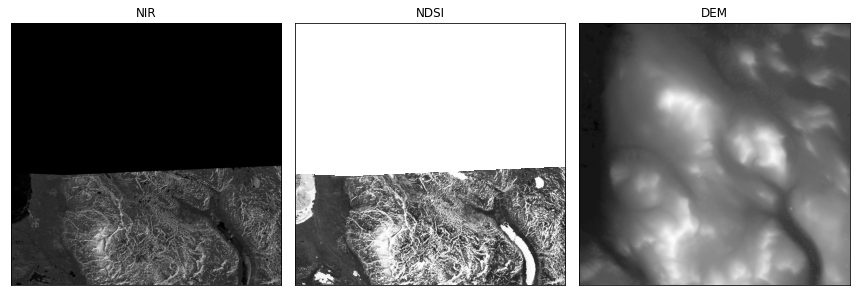

NEW file name: Nor_snow_2.tif
FILE LIST ['Resampled_Norb3 4.tif', 'b08_nor_bbox3_15.tif', 'NDSI_nor_bbox3_15.tif']
	-Resampled_Norb3 4.tif
	-b08_nor_bbox3_15.tif
	-NDSI_nor_bbox3_15.tif
ALL BANDS path: ['Resampled_Norb3 4.tif', 'b08_nor_bbox3_15.tif', 'NDSI_nor_bbox3_15.tif']
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': 30.279888153076172, 'width': 2323, 'height': 2159, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00020982780886784322, 0.0, 11.68324,
       0.0, -8.991662806855083e-05, 64.72623)}
NEW TIF: Nor_snow_2.tif


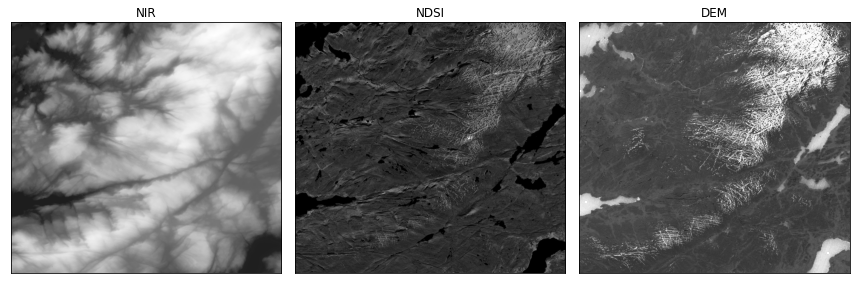

NEW file name: Nor_snow_3.tif
FILE LIST ['Resampled_Norb3 3.tif', 'b08_nor_bbox3_14.tif', 'NDSI_nor_bbox3_14.tif']
	-Resampled_Norb3 3.tif
	-b08_nor_bbox3_14.tif
	-NDSI_nor_bbox3_14.tif
ALL BANDS path: ['Resampled_Norb3 3.tif', 'b08_nor_bbox3_14.tif', 'NDSI_nor_bbox3_14.tif']
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': 30.279888153076172, 'width': 2323, 'height': 2159, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00020982780886784322, 0.0, 11.68324,
       0.0, -8.991662806855083e-05, 64.72623)}
NEW TIF: Nor_snow_3.tif


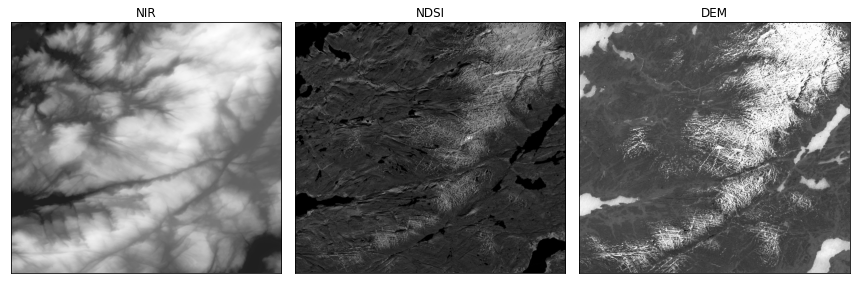

NEW file name: Nor_snow_4.tif
FILE LIST ['Resampled_Norb3 2.tif', 'NDSI_nor_bbox3_7.tif', 'b08_nor_bbox3_7.tif']
	-Resampled_Norb3 2.tif
	-NDSI_nor_bbox3_7.tif
	-b08_nor_bbox3_7.tif
ALL BANDS path: ['Resampled_Norb3 2.tif', 'NDSI_nor_bbox3_7.tif', 'b08_nor_bbox3_7.tif']
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': 30.279888153076172, 'width': 2323, 'height': 2159, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00020982780886784322, 0.0, 11.68324,
       0.0, -8.991662806855083e-05, 64.72623)}
NEW TIF: Nor_snow_4.tif


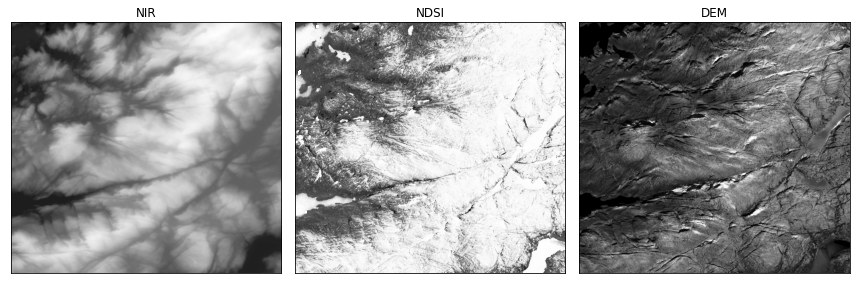

NEW file name: Nor_snow_5.tif
FILE LIST ['NDSI_nor_bbox1_14.tif', 'b08_nor_bbox1_14.tif', 'Resampled_Norb1.tif']
	-NDSI_nor_bbox1_14.tif
	-b08_nor_bbox1_14.tif
	-Resampled_Norb1.tif
ALL BANDS path: ['NDSI_nor_bbox1_14.tif', 'b08_nor_bbox1_14.tif', 'Resampled_Norb1.tif']
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2335, 'height': 2271, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0001872034261241967, 0.0, 6.71053,
       0.0, -8.989431968295839e-05, 61.39842)}
NEW TIF: Nor_snow_5.tif


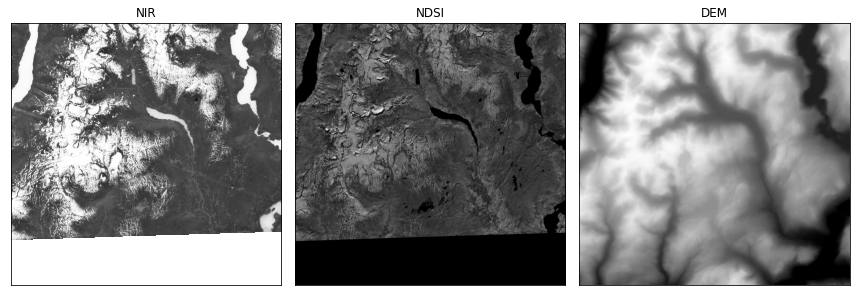

NEW file name: Nor_snow_6.tif
FILE LIST ['Resampled_Norb2 3.tif', 'NDSI_nor_bbox2_5.tif', 'b08_nor_bbox2_5.tif']
	-Resampled_Norb2 3.tif
	-NDSI_nor_bbox2_5.tif
	-b08_nor_bbox2_5.tif
ALL BANDS path: ['Resampled_Norb2 3.tif', 'NDSI_nor_bbox2_5.tif', 'b08_nor_bbox2_5.tif']
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': 75.10037994384766, 'width': 2291, 'height': 2229, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00019290266259275378, 0.0, 11.91172,
       0.0, -8.991027366531987e-05, 62.31454)}
NEW TIF: Nor_snow_6.tif


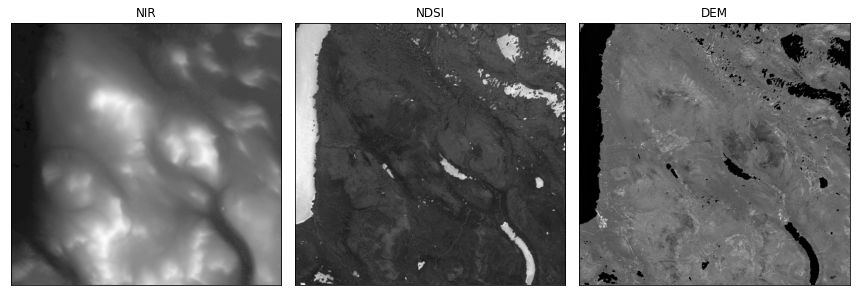

NEW file name: Nor_snow_7.tif
FILE LIST ['Resampled_Norb2 4.tif', 'NDSI_nor_bbox2_12.tif', 'b08_nor_bbox2_12.tif']
	-Resampled_Norb2 4.tif
	-NDSI_nor_bbox2_12.tif
	-b08_nor_bbox2_12.tif
ALL BANDS path: ['Resampled_Norb2 4.tif', 'NDSI_nor_bbox2_12.tif', 'b08_nor_bbox2_12.tif']
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': 75.10037994384766, 'width': 2291, 'height': 2229, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00019290266259275378, 0.0, 11.91172,
       0.0, -8.991027366531987e-05, 62.31454)}
NEW TIF: Nor_snow_7.tif


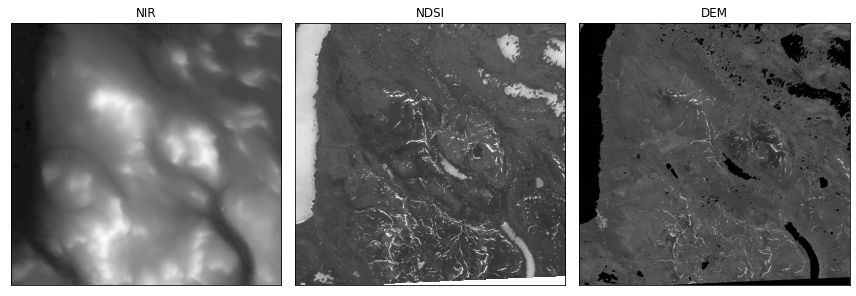

NEW file name: Nor_snow_8.tif
FILE LIST ['Resampled_Norb2 2.tif', 'b08_nor_bbox2_3.tif', 'NDSI_nor_bbox2_3.tif']
	-Resampled_Norb2 2.tif
	-b08_nor_bbox2_3.tif
	-NDSI_nor_bbox2_3.tif
ALL BANDS path: ['Resampled_Norb2 2.tif', 'b08_nor_bbox2_3.tif', 'NDSI_nor_bbox2_3.tif']
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': 75.10037994384766, 'width': 2291, 'height': 2229, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00019290266259275378, 0.0, 11.91172,
       0.0, -8.991027366531987e-05, 62.31454)}
NEW TIF: Nor_snow_8.tif


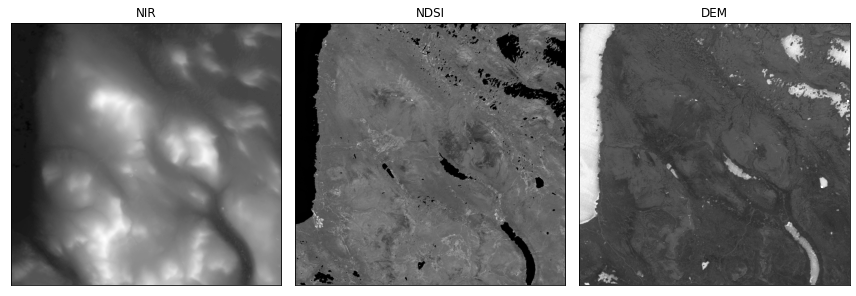

NEW file name: Nor_snow_9.tif
FILE LIST ['Resampled_Norb1 3.tif', 'b08_nor_bbox1_18.tif', 'NDSI_nor_bbox1_18.tif']
	-Resampled_Norb1 3.tif
	-b08_nor_bbox1_18.tif
	-NDSI_nor_bbox1_18.tif
ALL BANDS path: ['Resampled_Norb1 3.tif', 'b08_nor_bbox1_18.tif', 'NDSI_nor_bbox1_18.tif']
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': 64.11603546142578, 'width': 2335, 'height': 2271, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0001872034261241967, 0.0, 6.71053,
       0.0, -8.989431968295839e-05, 61.39842)}
NEW TIF: Nor_snow_9.tif


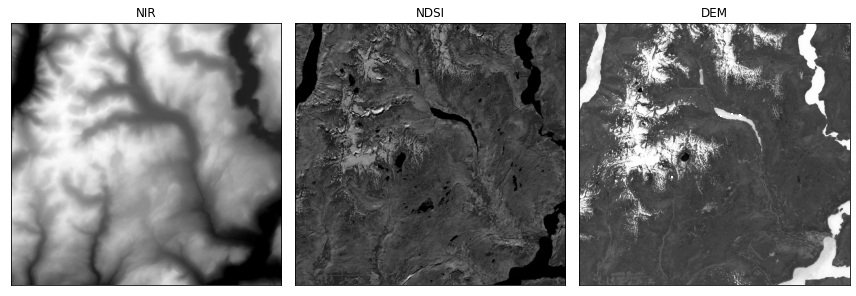

NEW file name: Nor_snow_10.tif
FILE LIST ['Resampled_Norb1 4.tif', 'b08_nor_bbox1_22.tif', 'NDSI_nor_bbox1_22.tif']
	-Resampled_Norb1 4.tif
	-b08_nor_bbox1_22.tif
	-NDSI_nor_bbox1_22.tif
ALL BANDS path: ['Resampled_Norb1 4.tif', 'b08_nor_bbox1_22.tif', 'NDSI_nor_bbox1_22.tif']
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': 64.11603546142578, 'width': 2335, 'height': 2271, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0001872034261241967, 0.0, 6.71053,
       0.0, -8.989431968295839e-05, 61.39842)}
NEW TIF: Nor_snow_10.tif


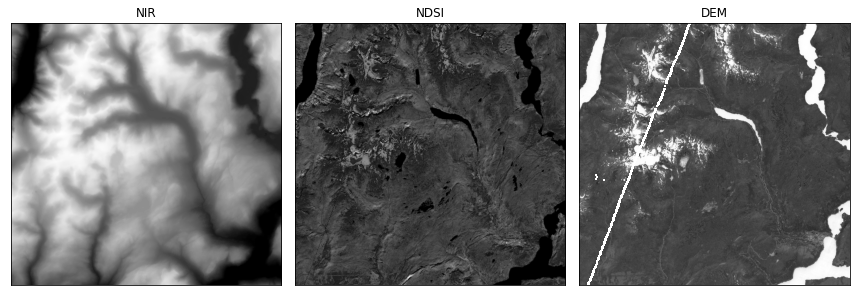

NEW file name: Nor_snow_11.tif
FILE LIST ['b08_nor_bbox3_3.tif', 'Resampled_Norb3.tif', 'NDSI_nor_bbox3_3.tif']
	-b08_nor_bbox3_3.tif
	-Resampled_Norb3.tif
	-NDSI_nor_bbox3_3.tif
ALL BANDS path: ['b08_nor_bbox3_3.tif', 'Resampled_Norb3.tif', 'NDSI_nor_bbox3_3.tif']
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': 46.353614807128906, 'width': 2323, 'height': 2159, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00020982780886784322, 0.0, 11.68324,
       0.0, -8.991662806855083e-05, 64.72623)}
NEW TIF: Nor_snow_11.tif


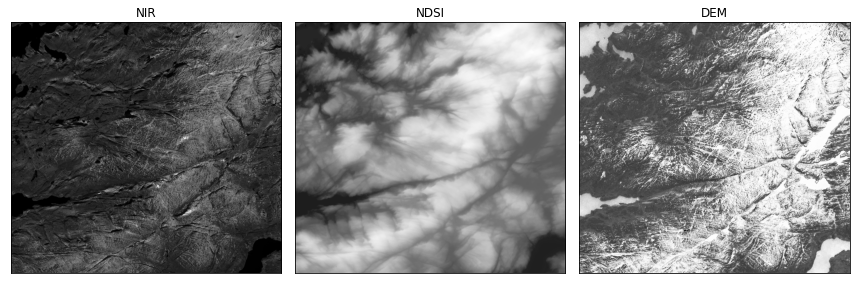

NEW file name: Nor_snow_12.tif
FILE LIST ['Resampled_Norb1 5.tif', 'b08_nor_bbox1_36.tif', 'NDSI_nor_bbox1_36.tif']
	-Resampled_Norb1 5.tif
	-b08_nor_bbox1_36.tif
	-NDSI_nor_bbox1_36.tif
ALL BANDS path: ['Resampled_Norb1 5.tif', 'b08_nor_bbox1_36.tif', 'NDSI_nor_bbox1_36.tif']
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': 64.11603546142578, 'width': 2335, 'height': 2271, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0001872034261241967, 0.0, 6.71053,
       0.0, -8.989431968295839e-05, 61.39842)}
NEW TIF: Nor_snow_12.tif


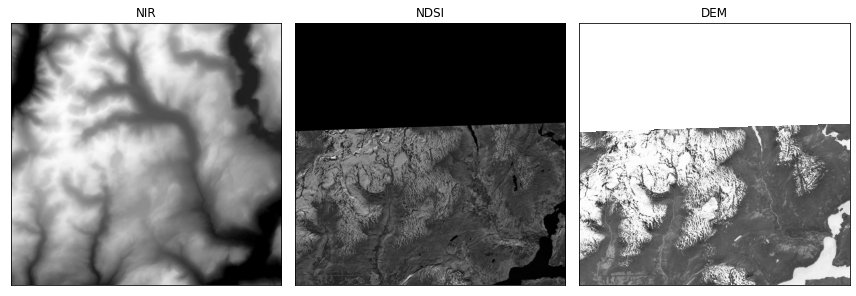

NEW file name: Nor_snow_13.tif
FILE LIST ['Resampled_Norb1 2.tif', 'NDSI_nor_bbox1_15.tif', 'b08_nor_bbox1_15.tif']
	-Resampled_Norb1 2.tif
	-NDSI_nor_bbox1_15.tif
	-b08_nor_bbox1_15.tif
ALL BANDS path: ['Resampled_Norb1 2.tif', 'NDSI_nor_bbox1_15.tif', 'b08_nor_bbox1_15.tif']
META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': 64.11603546142578, 'width': 2335, 'height': 2271, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0001872034261241967, 0.0, 6.71053,
       0.0, -8.989431968295839e-05, 61.39842)}
NEW TIF: Nor_snow_13.tif


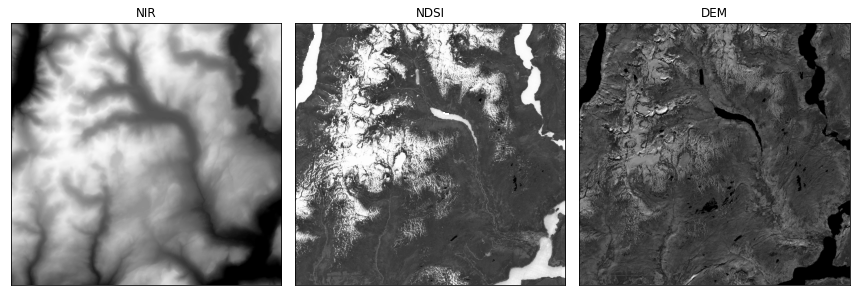

In [153]:
# stack DEM, NIR and NDSI and save as final .tif
# EarthPy has a stack() function that allows you to take a set of .tif files that are all in the same 
# spatial extent, CRS and resolution and either export them together a single stacked .tif file or work with them in Python directly as a stacked numpy array.

# use es.stack() function of earthpy library to create a raster stack of multi-band raster. It need three steps:

#Create a raster list using glob() function
#Create a path and define a name for mutli-band raster
#Apply es.stack() to creat new stacked raster with all bands save as multi tif
#Then apply rio.open to read the raster bands


import os
import glob
import earthpy.plot as ep
import earthpy.spatial as es
import rasterio as rio

import os
os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Final_files/organised_to_stack/Norway')

directory_to_check = "/Users/emilybirch/Documents/UCL_Dissertation/Final_files/organised_to_stack/Norway" 

# Get all the subdirectories of directory_to_check recursively and store them in a list:
directories = [os.path.abspath(x[0]) for x in os.walk(directory_to_check)]
directories.remove(os.path.abspath(directory_to_check)) # If you don't want your main directory included



def stack_array(all_bands_list, new_tif_path):  
    """
    stack DEM, raw NDSI and NIR (b08)
    download multi-band .tif of all three bands

    """ 
    print("\t-" + "\n\t-".join(os.listdir("."))) # List current working directory
    all_bands_list = all_bands_list 
    print("ALL BANDS path:", all_bands_list)
    with rio.open(all_bands_list[0]) as src:
        meta = src.meta
        print("META:",meta)
        # Update meta to reflect the number of layers
        meta.update(count = len(all_bands_list))
        new_stacked_tif = new_tif_path
        print("NEW TIF:", new_stacked_tif)
        band_stack, bands_meta = es.stack(all_bands_list,
                                        new_stacked_tif)      
        with rio.open(new_stacked_tif) as src:
            sentinel_multi = src.read() 
        os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Final_files/Stacked_tifs')
        # plot all bands
        band_titles = ["NIR", "NDSI", "DEM"]
        ep.plot_bands(sentinel_multi,
                  title=band_titles, cbar=False)
        plt.show()
  



 
i = 0
for subdir in directories:
    i += 1
    os.chdir(subdir)         # Change working Directory
    new_tif_path = 'Nor_snow_{}.tif'.format(i)
    print("NEW file name:", new_tif_path)
    list_files = glob.glob('*.tif')
    print("FILE LIST", list_files)
    stack = stack_array(list_files, new_tif_path)  # run func
    
    
        
# LABEL SAME AS SNOW LABELLED PICS

# Arg_snow_labelled_ !!!!!! convert to float32
# FR_snow_labelled_
#CN_snow_labelled_
# NZ_snow_labelled_
# Al_snow_
# Nor_snow_

                    
    
# NOT LABELLING THEM WITH IN ORDER NAMES/NUMBERS SO CHANGE THIS SO IT MATCHES THE NSOW LABELLED PICS


# Call for one individual pic:
#os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/stacked/Argentina/ArgB3_pic12')
#os.getcwd()
#arg_bands_list = ['new_DEM_box3_pic10.tif', 'float_NDSI_arg_bbox3_5.tif', 'float_b08_arg_bbox3_5.tif'] 
# export as same name as snow labelled pis  

#new_tif_path = 'Arg_snow_labelled_12.tif'

# call stack func
#arg_box3_pic10 = stack_array(arg_bands_list, new_tif_path)



In [ ]:

# TEST TO SEE IF LABELS ARE JUST BLACK 0 AND WHITE 255:

import numpy as np
from PIL import Image
import os

path = '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/WCS_req_RGB/CORRECTED_SNOW_LABELLED'
print(path)
list_of_pics = os.listdir(path)

#for i in range(len(label_dir)):
#    i_label = label_dir[i]
#    print("labelled file name", i_label)
im = 'maybe_works_test.png'

label_png = np.array(Image.open(os.path.join(path, im))) # i_label
array = label_png
print("orig array", array)
print("Minimum value in the whole original array:%d"%(array.min()))
print("Maximum value in the whole original array:%d"%(array.max()))
# all pics should just have 255 and 0 for white/black
print(np.unique(array)) # PRINT ALL UNIQUE VALUES IN ARRAY







In [ ]:
label_dir = sorted(os.listdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/FINAL/ALL_snow_labelled')) # FINAL/ALL_snow_labelled
print(label_dir)

In [ ]:
    #print("shape of orig arr", array.shape[0])
    # make all snow 1 values into 255. pics should be only 0 for black and 255 for white 
    #normalise_array = array * 255
    # see if numbers are now 0 and 255
    #print(np.unique(normalise_array))
   # print(normalise_array)
    #print("Minimum value in the whole RESIZED tif array:%d"%(array.max()))
    
    # Resize the array for the correct splitting dimensions. 
    # This basically makes new width/height of pics so that its perfectly divisible by 244x244 mini pics
   # array_height = int((normalise_array.shape[0] / 244)) * 244 # int((array.shape[0] / 244)) * 244
    #print("shape of resized arr", array.shape[0])
    #array_width = int((normalise_array.shape[1] / 244)) * 244 # / array.shape[1])) * 244?

    
    # all pixels are resized to 0-1 after resize function??
   # resized_array = resize(normalise_array, (array_height, array_width))
   # print("resized array shape", (resized_array.shape[1]))

In [15]:
#split data
# WORKS !!!!

import gdal
import image_slicer
import math
import os
from PIL import Image
from skimage.transform import resize   
import numpy as np  


# Split the Images
def split_image(dim_pix, im):
    # Find the number of sub-Images that fit in rows
    rows = []
    tiles = []
    for i in range((math.floor(im.shape[0] / dim_pix))):
        rows.append(i)
    # Find the number of sub-Images that fit in rows
    columns = []
    for i in range((math.floor(im.shape[1] / dim_pix))):
        columns.append(i)

    # Numerically identify the sub-Images
    a = 0
    for i in rows:
        for j in columns:
            # Check for 244 x 244 (Mask) or 244 x 244 x 3 (TC Images)
            if (im[0 + (dim_pix * j): dim_pix + (dim_pix * j),
                  0 + dim_pix * i: dim_pix + (dim_pix * i)].shape[0]) == dim_pix:
                if (im[0 + (dim_pix * j): dim_pix + (dim_pix * j),
                  0 + dim_pix * i: dim_pix + (dim_pix * i)].shape[1]) == dim_pix:

                    tile = im[0 + (dim_pix * j): dim_pix + (dim_pix * j),
                            0 + dim_pix * i: dim_pix + (dim_pix * i)]

                    # Stop white tiles for positive results
                    count = np.count_nonzero(tile == 1) == (dim_pix * dim_pix)
                    if count:
                        all_black = np.tile(1, (dim_pix, dim_pix))
                        tiles.append(tile)
                    else:
                        tiles.append(tile)
                    a += 1
                else:
                    print("Out of shape")
    return tiles


######################################################################

# set dir
label_dir = sorted(os.listdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/WCS_req_RGB/RESTOF_CORRECTLY_SNOW_LABELLED')) # FINAL/ALL_snow_labelled
img_dir = sorted(os.listdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/TRAINING_SUBSET/2000_ndsi_dem_nir_tifs')) # *.tif Data_collection/FINAL/ALL_stacked_tifs


import glob
import os 
from PIL import Image
import sys

import earthpy.plot as ep
import earthpy.spatial as es
import rasterio as rio



# rescale between 0-255
# pixel height / (max pixel height) gives 0-1
# then * 255 
# then make an integer and save?


input_tensor_dimensions = 244


for i in range(len(img_dir)):
    i_label = label_dir[i]
    print("labelled file name", i_label)
    # split the individual files in dir
    name = i_label.split(".")[0]
    os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/WCS_req_RGB/RESTOF_CORRECTLY_SNOW_LABELLED') # FINAL/ALL_snow_labelled
    # read png labelled pics in as array  
    label_png = np.array(Image.open(i_label))
    array = label_png
    print("orig", (np.unique(array)))
    #print("shape of orig arr", array.shape[0])
    # make all snow 1 values into 255. pics should be only 0 for black and 255 for white 
    normalise_array = array * 255
    # see if numbers are now 0 and 255
    print(np.unique(normalise_array))
   # print(normalise_array)
    #print("Minimum value in the whole RESIZED tif array:%d"%(array.max()))
    
    # Resize the array for the correct splitting dimensions. 
    # This basically makes new width/height of pics so that its perfectly divisible by 244x244 mini pics
   # array_height = int((normalise_array.shape[0] / 244)) * 244 # int((array.shape[0] / 244)) * 244
    #print("shape of resized arr", array.shape[0])
    #array_width = int((normalise_array.shape[1] / 244)) * 244 # / array.shape[1])) * 244?

    
    # all pixels are resized to 0-1 after resize function??
   # resized_array = resize(normalise_array, (array_height, array_width))
   # print("resized array shape", (resized_array.shape[1]))

    # Check for 244 x 244 (Mask) or 244 x 244 x 3 (TC Images)
    label_tiles = split_image(dim_pix=input_tensor_dimensions, im=normalise_array) # resized_array
    print(label_tiles)
    n = len(label_tiles)
    print("n", n)
   # if n!= min(array_height/244,array_width/244) **2:
    #    print(name)

                
    os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/TRAINING_SUBSET/NDSI_DEM_NIR/PNGLabels') #save path to split labelled pic
    for index in range(n):
        # name the output labelled pic and save as png file 
        outfile_png = name + "_" + str(index+1) + ".png"
        print("out file png", outfile_png)
        # make array of output file
        # HERE MY PICS SHOULD BE 1 FOR WHITE AND 0 FOR BLACK
        im = Image.fromarray((label_tiles[index]).astype(np.uint8))
        #print("shape of label tiles im", im.shape[0])
        #print("shape of label tiles im", im.shape[1])
        im = Image.fromarray((label_tiles[index]).astype(np.uint8)) # this makes values 255 * 255
        #print("UNIQUE NO.", np.unique(im))
       # print("Minimum value in the whole RESIZED array:%d"%(im.min()))
       # print("Maximum value in the whole RESIZED array:%d"%(im.max()))
      #  print("im x 255", im)
        # save output 
        im.save(outfile_png) #HERE TO SAVE SPLIT LABELLED PIC
    
    
    
    
    # the 3 channnel pic. (NIR, DEM, NDSI) pic
    tif_image = "{}{}".format(name, ".tif") # change to .tif !!!!!!
    
    i_image = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/TRAINING_SUBSET/2000_ndsi_dem_nir_tifs/{}".format(tif_image) # FINAL/ALL_stacked_tifs/
    print("tif image file name",i_image)
    os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/TRAINING_SUBSET/2000_ndsi_dem_nir_tifs') # Data_collection/FINAL/ALL_stacked_tifs
    print("i image", i_image)
    img_jpg = gdal.Open(i_image)
    print("image jpg", img_jpg)
    array = img_jpg.ReadAsArray()
    # Resize the array for the correct splitting dimensions for a tif 
   # array_height = int((array.shape[1] / 244)) * 244 # all pixels are resized to 0-1 after resize function
   # print("tif resized array_height", array_height)
   # array_width = int((array.shape[2] / 244)) * 244
   # print("tif resize array_width", array_width)
    
    # REDEFINE THIS TO TIF DIMENSIONS
    resized_array = resize(array, (array_height, array_width, 3)) # all pixels resized to
    print("tif arr", resized_array)
    #print("Minimum value in the whole RESIZED tif array:%d"%(resized_array.min()))
    #print("Maximum value in the whole RESIZEDtif  array:%d"%(resized_array.max()))
    
    # CANT JUST SAVE AS .TF- HAVE TO WRITE TIF FILE 
    
    basemap_tiles = split_image(dim_pix=input_tensor_dimensions, im=resized_array)
    print("len basemap tiles", len(basemap_tiles))
    os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/TRAINING_SUBSET/NDSI_DEM_NIR/TifImages') #save path Data_collection/FINAL/test_tif
    for ind in range(len(basemap_tiles)):
        # save the .tifs as jpegs for input into model?
        outfile_tif = name + "_" + str(ind+1) + ".tif"
        print("index", ind)
        im = Image.fromarray((basemap_tiles[ind] * 255).astype(np.uint8))
        
       # im.save(outfile_tif)
        

os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/stacked/Argentina') 

directory_to_check = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/stacked/Argentina" 

# Get all the subdirectories of directory_to_check recursively and store them in a list:
directories = [os.path.abspath(x[0]) for x in os.walk(directory_to_check)]
directories.remove(os.path.abspath(directory_to_check)) # If you don't want your main directory included



def stack_array(all_bands_list, new_tif_path):  
    """
    stack DEM, raw NDSI and NIR (b08)
    download multi-band .tif of all three bands

    """ 
    print("\t-" + "\n\t-".join(os.listdir("."))) # List current working directory
    all_bands_list = all_bands_list 
    print("ALL BANDS path:", all_bands_list)
    
    
    with rio.open(all_bands_list[0]) as src:
        meta = src.meta
        print("META:",meta)
        # Update meta to reflect the number of layers
        meta.update(count = len(all_bands_list))
        new_stacked_tif = new_tif_path
        print("NEW TIF:", new_stacked_tif)
        band_stack, bands_meta = es.stack(all_bands_list,
                                        new_stacked_tif)      
        with rio.open(new_stacked_tif) as src:
            sentinel_multi = src.read() 
        os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/stacked/Final_stacked_imagery')
        # plot all bands
        band_titles = ["NIR", "NDSI", "DEM"]
        ep.plot_bands(sentinel_multi,
                  title=band_titles, cbar=False)
        plt.show()
     
    
# ITS BAD TO RELY ON INDEXES TO MATCH UP  so need to sort the files when i open the directroy
# n for length of tiles needs to be diff for basemap and label tiles so that 'list index is NOT out of range'



labelled file name CN_snow_labelled_11.png
orig [0 1]
[array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
     

out file png CN_snow_labelled_11_37.png
out file png CN_snow_labelled_11_38.png
out file png CN_snow_labelled_11_39.png
out file png CN_snow_labelled_11_40.png
out file png CN_snow_labelled_11_41.png
out file png CN_snow_labelled_11_42.png
out file png CN_snow_labelled_11_43.png
out file png CN_snow_labelled_11_44.png
out file png CN_snow_labelled_11_45.png
out file png CN_snow_labelled_11_46.png
out file png CN_snow_labelled_11_47.png
out file png CN_snow_labelled_11_48.png
out file png CN_snow_labelled_11_49.png
out file png CN_snow_labelled_11_50.png
out file png CN_snow_labelled_11_51.png
out file png CN_snow_labelled_11_52.png
out file png CN_snow_labelled_11_53.png
out file png CN_snow_labelled_11_54.png
out file png CN_snow_labelled_11_55.png
out file png CN_snow_labelled_11_56.png
out file png CN_snow_labelled_11_57.png
out file png CN_snow_labelled_11_58.png
out file png CN_snow_labelled_11_59.png
out file png CN_snow_labelled_11_60.png
out file png CN_snow_labelled_11_61.png


KeyboardInterrupt: 

In [ ]:
###################################################

In [ ]:
# plot the split pics out

import matplotlib.pyplot as plt


pic_files = os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/FINAL/plot')
openfiles = glob.glob('*.png') # , '*.png' pic_files
#print("openfiles", openfiles)

for pic in openfiles:
    picture =  gdal.Open(pic) 
    array = picture.ReadAsArray()
    plt.imshow (array, cmap='Blues')




#fig, ax = plt.subplots(32, 32, figsize=(2 ,32))
#for index in range(32):
#    plt.axis('off')
 #   #ax[index, 0].axis('off')
 #   ax[index, 1].axis('off')
 #   ax[index, 1].imshow(openfiles[index], cmap='Blues')





In [ ]:
w = 10
h = 10
fig = plt.figure(figsize=(2, 32))
columns = 32
rows = 32
for i in range(1, columns*rows +1):
    img = 
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()


BELOW IS ALL THE EXTRA CODE USEFUL FOR PREPROCESSING:

In [ ]:
# FILES HAVE MOVED, DO NOT NEED TO RUN AGAIN

# mMove and rename the single .tif tiles which do not need merging
# France bbox 2. only 1 tile, so move to final DEMs folder and rename
import shutil
shutil.move('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/France/BOX2/tifs/ALPSMLC30_N044E006_DSM.tif', '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Directory_for_DEM/Final_DEM_pics/mergedFrDEM2.tif')

# Alaska: only 1 tif per. bbox2 and bbox4
import shutil
shutil.move('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Alaska/BOX2/tifs/ALPSMLC30_N060W145_DSM.tif', '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Directory_for_DEM/Final_DEM_pics/mergedAlDEM2.tif')
shutil.move('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Alaska/BOX4/tifs/ALPSMLC30_N061W146_DSM.tif', '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Directory_for_DEM/Final_DEM_pics/mergedAlDEM4.tif')

# Argentina
import shutil
shutil.move("/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Argentina/BOX1/tifs/ALPSMLC30_S036W070_DSM.tif", '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Directory_for_DEM/Final_DEM_pics/mergedArgDEM1.tif')
shutil.move("/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Argentina/BOX2/tifs/ALPSMLC30_S036W071_DSM.tif", '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Directory_for_DEM/Final_DEM_pics/mergedArgDEM2.tif') 
shutil.move("/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Argentina/BOX3/tifs/ALPSMLC30_S048W072_DSM.tif", '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Directory_for_DEM/Final_DEM_pics/mergedArgDEM3.tif') 
    

In [ ]:
   # for index in range(n):

    os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/FINAL/ALL_stacked_tifs') 
    i = 0
    for file in img_dir:
        i += 1 
        print(type(file))
        #i_image = file
        #name = i_image.split(".")[0]
        img_jpg = gdal.Open(file)
        print(type(img_jpg))
        array = img_jpg.ReadAsArray()
        # Resize the array for the correct splitting dimensions for a tif 
        array_height = int((array.shape[1] / 244)) * 244 # all pixels are resized to 0-1 after resize function
        array_width = int((array.shape[2] / 244)) * 244

        # REDEFINE THIS TO TIF DIMENSIONS
        resized_array = resize(array, (array_height, array_width, 3)) # all pixels resized to
        basemap_tiles = split_image(dim_pix=input_tensor_dimensions, im=resized_array)
        n = len(basemap_tiles)
        # save the .tifs as jpegs for input into model?
        #outfile_jpg = name + "_" + str(index+1) + ".jpg"
        os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/FINAL/ttt') #save path
        outfile_jpg = file + '_{}.jpg'.format(i)
        #open_outfile = gdal.Open(open_outfile)
        #print(type(outfile_jpg))
        #outfile_array = outfile_jpg.ReadAsArray()
        # * by 255 to normalise array
        im = Image.fromarray(np.uint8(basemap_tiles)* 255)
        #img_jpg.astype(np.uint8)) #[index] * 255    
        im.save(outfile_jpg)

In [ ]:
# merge DEM tiles for each bbox
import os 
from osgeo import gdal
import glob
import subprocess
import gdal
from gdalconst import GA_ReadOnly


# set dir
os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Directory_for_DEM/merge')
os.getcwd()



# Alaska.2,3,4
# Set path to DEM tif files


alask_path3 = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Alaska/BOX3/tifs/*.tif"
alask_path4 = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Alaska/BOX4/tifs/*.tif"
#retrieve files with this path name and extension

al_DEM_list3 = glob.glob(alask_path3)
al_DEM_list4 = glob.glob(alask_path4)


# bbox3 merge
cmd = "gdal_merge.py -o mergedAlDEM3.tif"
subprocess.call(cmd.split()+al_DEM_list3)

cmd = "gdal_merge.py -o mergedAlDEM4.tif"
subprocess.call(cmd.split()+al_DEM_list4)




# merge Argentina 
arg_path2 = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Alaska/BOX2/tifs/*.tif"
arg_path3 = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Alaska/BOX3/tifs/*.tif"
#retrieve files with this path name and extension

al_DEM_list2 = glob.glob(arg_path2)
al_DEM_list3 = glob.glob(arg_path3)


# bbox3 merge
cmd = "gdal_merge.py -o mergedArgDEM2.tif"
subprocess.call(cmd.split()+al_DEM_list2)

cmd = "gdal_merge.py -o mergedArgDEM3.tif"
subprocess.call(cmd.split()+al_DEM_list3)






In [ ]:

# NZ. 4 bbox
nz_path3 = '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/NZ/BBOX3/tifs/*.tif'
nz_path4 = '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/NZ/BBOX4/tifs/*.tif'

nz_DEM_list3 = glob.glob(nz_path3)
nz_DEM_list4 = glob.glob(nz_path4)

# call subprocess gdal merge to merge the DEM tiles
cmd = "gdal_merge.py -o mergedNzDEM3.tif"
subprocess.call(cmd.split()+nz_DEM_list3)
# bbox3 merge
cmd = "gdal_merge.py -o mergedNzDEM4.tif"
subprocess.call(cmd.split()+nz_DEM_list4)


# CANADA. make a list of DEM files to merge. get all with .tif extension
can_bbox1_path = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Canada/BBOX1/tifs/*.tif"
can_bbox2_path = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Canada/BBOX2/tifs/*.tif"
can_bbox3_path = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Canada/BBOX3/tifs/*.tif"
# retrieve files with this path name and extension
CanDEMList_1 = glob.glob(can_bbox1_path)
CanDEMList_2 = glob.glob(can_bbox2_path)
CanDEMList_3 = glob.glob(can_bbox3_path)
print("CANB3:", CanDEMList_3)
print(CanDEMList_3)

# call subprocess gdal merge to merge the DEM tiles
cmd = "gdal_merge.py -o mergedCanDEM1.tif"
subprocess.call(cmd.split()+CanDEMList_1)
# Canada bbox2 merge
cmd = "gdal_merge.py -o mergedCanDEM2.tif"
subprocess.call(cmd.split()+CanDEMList_2)
# Canada bbox3 merge
cmd = "gdal_merge.py -o mergedCanDEM3.tif"
subprocess.call(cmd.split()+CanDEMList_3)


# France. Set path to DEM tif files
fr_bbox1 = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/France/BBOX1/tifs/*.tif"
fr_bbox3 = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/France/BOX3/tifs/*.tif"
#retrieve files with this path name and extension
fr_list1 = glob.glob(fr_bbox1)
fr_list3 = glob.glob(fr_bbox3)

# merge the DEM tiles. bbox1
cmd = "gdal_merge.py -o mergedFrDEM1.tif"
subprocess.call(cmd.split()+fr_list1)
# Fr bbox3 merge
cmd = "gdal_merge.py -o mergedFrDEM3.tif"
subprocess.call(cmd.split()+fr_list3)



# Norway
nor_path1 = '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Norway/bbox1/tifs/*.tif'
nor_path2 = '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Norway/bbox2/tifs/*.tif'
nor_path3 = '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Norway/bbox3/tifs/*.tif'

NorDEMList_1 = glob.glob(nor_path1)
NorDEMList_2 = glob.glob(nor_path2)
NorDEMList_3 = glob.glob(nor_path3)
print(CanDEMList_3)

# call subprocess gdal merge to merge the DEM tiles
cmd = "gdal_merge.py -o mergedNorDEM1.tif"
subprocess.call(cmd.split()+NorDEMList_1)
# Canada bbox2 merge
cmd = "gdal_merge.py -o mergedNorDEM2.tif"
subprocess.call(cmd.split()+NorDEMList_2)
# Canada bbox3 merge
cmd = "gdal_merge.py -o mergedNorDEM3.tif"
subprocess.call(cmd.split()+NorDEMList_3)


In [ ]:
# clip to extent of another raster file
data = gdal.Open('can_sat_1_1.png', GA_ReadOnly)
print(data)
geoTransform = data.GetGeoTransform()
print("GEO", geoTransform)
minx = geoTransform[0]
print("MIN", minx)
maxy = geoTransform[3]
print("MAX", maxy)
maxx = minx + geoTransform[1] * data.RasterXSize
miny = maxy + geoTransform[5] * data.RasterYSize
call('gdal_translate -projwin ' + ' '.join([str(x) for x in [minx, maxy, maxx, miny]]) + ' -of GTiff mergedCanDEM1.tif cropCanDEM1.tif', shell=True)


In [ ]:
# clip to extent of sample pic
import numpy as np
import rasterio
from rasterio import features
from rasterio.mask import mask


# ****** make this path have both dem and NIR pics in
os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Directory_for_DEM/DEM_pics')
os.getcwd()

# the first one is your raster on the right. use the single band NIR .tif to crop to
# and the second one your red raster
with rasterio.open('b08_can_bbox1_1') as src, \
        rasterio.open('mergedCanDEM1.tif') as src_to_crop:
    src_affine = src.meta.get("transform") # this is s,w,n,e, height, width, pixel size etc.

    # Read the first band of the "mask" raster
    band = src.read(1)
    # Use the same value on each pixel with data
    # in order to speedup the vectorization
    band[np.where(band!=src.nodata)] = 1

    geoms = []
    for geometry, raster_value in features.shapes(band, transform=src_affine):
        # get the shape of the part of the raster
        # not containing "nodata"
        if raster_value == 1:
            geoms.append(geometry)

    # crop the second raster using the
    # previously computed shapes
    out_img, out_transform = mask(
        dataset=src_to_crop,
        shapes=geoms,
        crop=True,
    )

    # save the result
    # (don't forget to set the appropriate metadata)
    with rasterio.open(
        'result.tif',
        'w',
        driver='GTiff',
        height=out_img.shape[1],
        width=out_img.shape[2],
        count=src.count,
        dtype=out_img.dtype,
        transform=out_transform,
    ) as dst:
        dst.write(out_img)


In [ ]:
# Process DEM geomorphology pics 
# merge DEM tiles, reproject to projected crs with m units, resample to 10x10m pixel size, crop to bbox
import os 
from osgeo import gdal
import glob
import subprocess
from gdal import gdalconst



# set directory to location of all final DEM pics 
os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Directory_for_DEM/Final_DEM_pics')
os.getcwd()

# can_list = [can_bbox1_path, can_bbox2_path, can_bbox3_path]
# i = 0
#for f in can_list:
    # i += 1
    # glob.glob(f)
    # cmd = "gdal_merge.py -o 'mergedCanDEM1_{}.tif'.format(i)"
    # subprocess.call(cmd.split()+f)

# CANADA. make a list of DEM files to merge. get all with .tif extension
can_bbox1_path = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Canada/BBOX1/tifs/*.tif"
can_bbox2_path = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Canada/BBOX2/tifs/*.tif"
can_bbox3_path = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Canada/BBOX2/tifs/*.tif"
# retrieve files with this path name and extension
CanDEMList_1 = glob.glob(can_bbox1_path)
CanDEMList_2 = glob.glob(can_bbox2_path)
CanDEMList_3 = glob.glob(can_bbox3_path)
print(CanDEMList_3)

# call subprocess gdal merge to merge the DEM tiles
cmd = "gdal_merge.py -o mergedCanDEM1.tif"
subprocess.call(cmd.split()+CanDEMList_1)
# Canada bbox2 merge
cmd = "gdal_merge.py -o mergedCanDEM2.tif"
subprocess.call(cmd.split()+CanDEMList_2)
# Canada bbox3 merge
cmd = "gdal_merge.py -o mergedCanDEM3.tif"
subprocess.call(cmd.split()+CanDEMList_3)



# France. Set path to DEM tif files
fr_bbox1 = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/France/BBOX1/tifs/*.tif"
fr_bbox3 = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/France/BOX3/tifs/*.tif"
#retrieve files with this path name and extension
fr_list1 = glob.glob(fr_bbox1)
fr_list3 = glob.glob(fr_bbox3)

# merge the DEM tiles. bbox1
cmd = "gdal_merge.py -o mergedFrDEM1.tif"
subprocess.call(cmd.split()+fr_list1)
# Fr bbox3 merge
cmd = "gdal_merge.py -o mergedFrDEM3.tif"
subprocess.call(cmd.split()+fr_list3)



# Alaska. Set path to DEM tif files
alask_path1 = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Alaska/BBOX1/tifs/*.tif"
alask_path3 = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Alaska/BOX3/tifs/*.tif"
#retrieve files with this path name and extension
al_DEM_list1 = glob.glob(alask_path1)
al_DEM_list3 = glob.glob(alask_path3)

# call subprocess gdal merge to merge the DEM tiles
cmd = "gdal_merge.py -o mergedAlDEM1.tif"
subprocess.call(cmd.split()+al_DEM_list1)
# bbox3 merge
cmd = "gdal_merge.py -o mergedAlDEM3.tif"
subprocess.call(cmd.split()+al_DEM_list3)



# reproject coordinate system into UTM to use metres as units 
def reproj(out_file, in_file, dstSRS):
    gdal.Warp(out_file, in_file, dstSRS = crs)

# zip over lists?
# reproj for Canada: into EPSG:3978
canada_reproj_list = ['mergedCanDEM1.tif', 'mergedCanDEM2.tif', 'mergedCanDEM3.tif']
i = 0
# for in_file in zip_longest(canada_reproj_list, fr_reproj_list,al_reproj_list,... )
for in_file in canada_reproj_list:
    i += 1
    print("I:", i)
    out_file = 'reprojCanDEM_{}.tif'.format(i)
    crs = 'EPSG:3978'
    call = reproj(out_file, in_file, crs)
    print(call)
    
    
# France: into EPSG:23030 ED50 / UTM zone 30N
fr_reproj_list =  ['mergedFrDEM1.tif', 'mergedFrDEM2.tif', 'mergedFrDEM3.tif']
i = 0
for in_file in fr_reproj_list:
    i += 1
    print("I:", i)
    out_file = 'reprojFrDEM_{}.tif'.format(i)
    crs = 'EPSG:23030'
    call = reproj(out_file, in_file, crs)
    print(call)
 
 
# reproj for Alaska: into EPSG:3338
al_reproj_list = ['mergedAlDEM1.tif', 'mergedAlDEM2.tif', 'mergedAlDEM3.tif', 'mergedAlDEM4.tif']
i = 0
for in_file in al_reproj_list:
    i += 1
    print("I:", i)
    out_file = 'reprojAlDEM_{}.tif'.format(i)
    crs = 'EPSG:3338'
    call = reproj(out_file, in_file, crs)
    print(call)
    
# reproj for Argentina: into EPSG:5343
Arg_reproj_list = ['mergedArgDEM1.tif', 'mergedArgDEM2.tif', 'mergedArgDEM3.tif']
i = 0

for in_file in Arg_reproj_list:
    i += 1
    print("I:", i)
    out_file = 'reprojArgDEM_{}.tif'.format(i)
    crs = 'EPSG:5343'
    call = reproj(out_file, in_file, crs)
    print(call)
    
    
    

# Resample to 10x10m pixel size to match Sentinel images
def resample(out_file, in_file):
    gdal.Warp(out_file, in_file, xRes = 10, yRes = 10, resampleAlg = "bilinear")
    print("HI")
        

# list the files to resample and process then in a loop 
resamp_files_list = ['reprojCanDEM_1.tif', 'reprojCanDEM_2.tif', 'reprojCanDEM_3.tif']    
i = 0
for in_file in resamp_files_list:
    i += 1
    print("i", i)
    out_file = "resamp_Can_DEM_{}.tif".format(i)
    print("OUTfile", out_file)
    resample(out_file, in_file)
            

# France: resample
resamp_list = ['reprojFrDEM_1.tif', 'reprojFrDEM_2.tif', 'reprojFrDEM_3.tif']    
i = 0
for in_file in resamp_list:
    i += 1
    print("i", i)
    out_file = "resamp_Fr_DEM_{}.tif".format(i)
    print("OUTfile", out_file)
    resample(out_file, in_file)

    
# Alaska resample. 
# list of files to resample
resamp_list = ['reprojAlDEM_1.tif', 'reprojalDEM_2.tif', 'reprojAlDEM_3.tif', 'reprojAlDEM_4.tif']    
i = 0
for in_file in resamp_list:
    i += 1
    print("i", i)
    out_file = "resamp_Al_DEM_{}.tif".format(i)
    print("OUTfile", out_file)
    resample(out_file, in_file)



# list the files to resample and process then in a loop 
resamp_files_list = ['reprojArgDEM_1.tif', 'reprojArgDEM_2.tif', 'reprojArgDEM_3.tif']    
i = 0
for in_file in resamp_files_list:
    i += 1
    print("i", i)
    out_file = "resamp_Arg_DEM_{}.tif".format(i)
    print("OUTfile", out_file)
    resample(out_file, in_file)
    
    
    
    
    
# Crop .tif to boudning box coords
def crop(out_file, source_file, ulx, uly, lrx, lry):
    gdal.Translate(out_file, source_file,
                  projWin = [ulx, uly, lrx, lry])
  

 
# Canada: crop .tif to boudning box coords
can1crop = crop('cropCanDEM_1.tif','resamp_Can_DEM_1.tif', -1442222.5901271082, 465767.00799028383, -1425280.668026976, 437053.54995778797) 
can2crop = crop('cropCanDEM_2.tif','resamp_Can_DEM_2.tif', -1963467.662479708, 532524.2456295489, -1950948.5651828928, 502730.9493941085)  
can3crop = crop('cropCanDEM_3.tif','resamp_Can_DEM_3.tif',-2007237.3331321548, 602651.3553773408, -1994916.2627411576, 570806.9080293514) 
       
# France: crop .tif to boudning box coords
Fr1crop = crop('cropFrDEM_1.tif','resamp_Can_DEM_1.tif',1246969.3962645088, 5163267.284300569,1274934.6912586447, 5143545.166937985) 
Fr2crop = crop('cropFrDEM_2.tif','resamp_Can_DEM_2.tif',1234624.7084396454, 4993062.539814649, 1261497.750934254, 4974014.1117675835)  
Fr3crop = crop('cropFrDEM_3.tif','resamp_Can_DEM_3.tif', 1225777.8855382334, 5373591.730970369,1252683.6911129407, 5355278.076760378) 

# Alaska: Crop .tif to boudning box coords
Al1crop = crop('cropAlDEM_1.tif','resamp_Al_DEM_1.tif', 514481.90383768355, 1236449.1310469457, 541830.6619147946, 1218503.1192803124) 
Al2crop = crop('cropAlDEM_2.tif','resamp_Al_DEM_2.tif', 450815.2605629388, 1223929.9128310417, 477228.41344957944, 1204727.699233261)  
Al3crop = crop('cropAlDEM_3.tif','resamp_Al_DEM_3.tif', 397957.2487422569, 1251934.8385985517,425182.4670500502, 1234086.2585198171) 
Al4crop = crop('cropAlDEM_4.tif','resamp_Al_DEM_4.tif',393282.9896072386, 1280321.0557472059,419319.2191957479, 1261199.193909528) 
  

# close datasets to read properly to disk
#ds = dsReproj = dsResamp = dsClip = None


In [ ]:
# plot to check DEM is reprojected, resampled and cropped to bbox
final_DEM = gdal.Open("cropDEM_2.tif")
array = final_DEM.ReadAsArray()
plt.imshow(array)
plt.colorbar()

In [ ]:
# Argentina
import os 
from osgeo import gdal
import glob
import subprocess
from gdal import gdalconst


# set directory to location of all final DEM pics 
os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Directory_for_DEM/Final_DEM_pics')
os.getcwd()

def crop(out_file, source_file, ulx, uly, lrx, lry):
    gdal.Translate(out_file, source_file,
                  projWin = [ulx, uly, lrx, lry])
    
  


 
# FIX THESE- CANT CROP BC NOT IN SAME AREA?
# Argentina: crop .tif to boudning box coords
Ar1crop = crop('cropArgDEM_1.tif','resamp_Arg_DEM_1.tif',5998451.786827491, 1601005.619190992,5976249.0203732345, 1625961.998551086) 
Ar2crop = crop('cropArgDEM_2.tif','resamp_Arg_DEM_2.tif',5937593.134678965, 1582258.6827567841,5916218.082539896, 1605918.8959056677)
Ar3crop = crop('cropArgDEM_3.tif','resamp_Arg_DEM_3.tif', 4676913.660264564, 1475051.4449760758, 4656287.012900037, 1499619.73136248) 


In [ ]:
# Norway
Nor1crop = crop('cropNorDEM_1.tif','resamp_Nor_DEM_1.tif',1611541.2847414473, -1150463.0893291135,1581199.9787365836, -1136330.787145058)
Nor2crop = crop('cropNorDEM_2.tif','resamp_Nor_DEM_2.tif',1619389.5743942696, -854804.3331045215,1591676.3046402216, -836971.2418011383)
Nor3crop = crop('cropNorDEM_3.tif','resamp_Nor_DEM_3.tif', 1882899.119273985, -786917.6157957469,1855046.293116921, -769771.7641124884) 




In [ ]:
# use more than one channel as input into my model. use geomorphology too.

# taking the TIFF data and encoding it to a TFRecords format for some machine learning in Tensorflow.  
# take the TIFF data, convert it to 8bit format, encode it as a string and write it to TFRecords.  


# A guide for Spectral indicies:
# https://www.geo.university/pages/blog?p=spectral-indices-with-multispectral-satellite-data


I chose a region where both water and snow are present. 
This shows that when trying to isolate snow, we also isolate water. 

But when isolating water, we, the snow is mostly left out.
This means that we can use both indicies to generate some training data

In [ ]:
def to_mask(input_image, threshold):
    input_image[input_image <= threshold] = np.nan
    input_image[input_image > threshold] = 1
    return input_image
    
NDVI_mask = to_mask(NDVI, 0.2)
NDSI_mask = to_mask(NDSI, 0.)
fig, ax = plt.subplots(1, 4, figsize=(15,10))
ax[0].set_title('NDVI Vegetation mask')
ax[0].imshow(basemap)
ax[0].imshow(NDVI_mask, cmap='cubehelix')
ax[1].set_title('NDSI Snow mask')
ax[1].imshow(basemap)
ax[1].imshow(NDSI_mask, cmap='cubehelix')

NDVI_binary_mask = np.nan_to_num(NDVI_mask)
NDSI_binary_mask = np.nan_to_num(NDSI_mask)
both = NDVI_binary_mask + NDSI_binary_mask

ax[2].set_title('NDSI mask + NDVI mask')
ax[2].imshow(both, cmap='cubehelix')

ax[3].set_title('Snow mask - Vegetation removed')
snow_only = both.copy()
snow_only[snow_only == 2] = 0
ax[3].imshow(snow_only, cmap='cubehelix')

CNN's usually don't accept big inputs, so the image needs to be cropped into smaller samples.

The bigger and more complex the CNN, the more processing power will be required, therefore the smaller the input samples will need to be. 

Rather than crushing the original sample, a good idea is to splice it. 
This way we get a lot more data, and the 10m resolution is maintained. 

In [ ]:
import math

# Split the Images
def split_image(dim_pix, im):
    # Find the number of sub-Images that fit in rows
    rows = []
    tiles = []
    for i in range((math.floor(im.shape[0] / dim_pix))):
        rows.append(i)
    # Find the number of sub-Images that fit in rows
    columns = []
    for i in range((math.floor(im.shape[1] / dim_pix))):
        columns.append(i)

    # Numerically identify the sub-Images
    a = 0
    for i in rows:
        for j in columns:
            # Check for 244 x 244 (Mask) or 244 x 244 x 3 (TC Images)
            if (im[0 + (dim_pix * j): dim_pix + (dim_pix * j),
                  0 + dim_pix * i: dim_pix + (dim_pix * i)].shape[0]) == dim_pix:
                if (im[0 + (dim_pix * j): dim_pix + (dim_pix * j),
                  0 + dim_pix * i: dim_pix + (dim_pix * i)].shape[1]) == dim_pix:

                    tile = im[0 + (dim_pix * j): dim_pix + (dim_pix * j),
                            0 + dim_pix * i: dim_pix + (dim_pix * i)]

                    # Stop white tiles for positive results
                    count = np.count_nonzero(tile == 1) == (dim_pix * dim_pix)
                    if count:
                        all_black = np.tile(1, (dim_pix, dim_pix))
                        tiles.append(tile)
                    else:
                        tiles.append(tile)
                    a += 1
                else:
                    print("Out of shape")
    return tiles

input_tensor_dimensions = 50
                    
basemap_tiles = split_image(dim_pix=input_tensor_dimensions, im=basemap)
label_tiles = split_image(dim_pix=input_tensor_dimensions, im=snow_only)

fig, ax = plt.subplots(len(label_tiles), 2, figsize=(2 ,len(label_tiles)))
for index in range(len(label_tiles)):
    ax[index, 0].axis('off')
    ax[index, 1].axis('off')
    ax[index, 0].imshow(basemap_tiles[index])
    ax[index, 1].imshow(label_tiles[index], cmap='Blues')

In [ ]:
# EXTRA!!!!

# EXTRA. func to convert bbox coords from geographic into projected system 
import os
import pyproj
from pyproj import Proj, transform

os.environ['PROJ_NETWORK'] = 'OFF'


def coord_conv(x1, y1, in_proj, out_proj):
    proj = pyproj.Transformer.from_crs(in_proj, out_proj)
    x2, y2 = proj.transform(x1, y1)
    print((x1, y1))
    print((x2, y2))
    return x2,y2


 
# 1. Canada:   #"epsg:4326", "epsg:3978"
#can_DEM_bbox1_ulc = coord_conv(51.02521, -116.09311, 4326, 3978)
#can_DEM_bbox1_lrc = coord_conv(50.82872, -115.73064, 4326, 3978)
# box2
#can_DEM_bbox2_ulc = coord_conv(49.7991, -123.27756,4326, 3978)
#can_DEM_bbox2_lrc = coord_conv(49.60459, -122.94316,4326, 3978)
# box3
#can_bbox3_ulc = coord_conv(50.19571, -124.25775,4326, 3978)
#can_bbox3_lrc = coord_conv(49.98687, -123.90537,4326, 3978)



# 2. France 
# bbox 1 
#Fr_bbox1_ulc = coord_conv(46.20907, 6.68394, 4326, 23030)
#Fr_bbox1_lrc = coord_conv(46.00317, 7.009, 4326, 23030)
# box2
#Fr_bbox1_ulc = coord_conv(44.71102, 6.27264,4326, 23030)
#Fr_bbox1_lrc = coord_conv(44.51403, 6.57913,4326, 23030)
# box3
#Fr_bbox1_ulc = coord_conv(48.09807, 6.75178,4326, 23030)
#Fr_bbox1_lrc = coord_conv(47.90479, 7.07567, 4326, 23030)


# Alaska
#Al_bbox1_uly = coord_conv(60.78013, -144.48842,4326, 3338)
#Al_bbox1_lrc = coord_conv(60.58568, -144.03959, 4326, 3338)

#Al_bbox2_uly = coord_conv(60.74539, -145.68114, 4326, 3338)
#Al_bbox2_lrc = coord_conv(60.54485, -145.24568, 4326, 3338)

#Al_bbox3_uly = coord_conv(61.04986, -146.59057, 4326, 3338)
#Al_bbox3_lrc = coord_conv(60.86339, -146.12749, 4326, 3338)

#Al_bbox4_uly = coord_conv(61.30673, -146.61838, 4326, 3338) 
#Al_bbox4_lrc = coord_conv(61.11029, -146.17618, 4326, 3338)


# Argentina
#Ar_bbox1_uly = coord_conv(-36.1567, -70.87755,4326, 5343)
#Ar_bbox1_lrc = coord_conv(-36.35381, -70.59671, 4326, 5343)

#Ar_bbox2_uly = coord_conv(-36.70684, -71.0794, 4326, 5343)
#Ar_bbox2_lrc = coord_conv(-36.89707, -70.81168, 4326, 5343)

#Ar_bbox3_uly = coord_conv(-48.05909, -72.3347, 4326, 5343)
#Ar_bbox3_lrc = coord_conv(-48.24508, -72.00512, 4326, 5343)


# Norway. ETRS89 / UTM is the projected CRS for Norway
Nor_bbox1_uly = coord_conv(61.39974, 6.71094,4326, 5130)
Ar_bbox1_lrc = coord_conv(61.19466, 7.15113, 4326, 5130)

Nor_bbox2_uly = coord_conv(62.31192, 11.90014, 4326, 5130)
Ar_bbox2_lrc = coord_conv(62.12052, 12.37392, 4326, 5130)

Nor_bbox3_uly = coord_conv(64.72578, 11.67157, 4326, 5130)
Nor_bbox3_lrc = coord_conv(64.53323, 12.179, 4326, 5130)




#####################
#can_list = []
# [51.02521, -116.09311,(49.7991, -123.27756), (50.19571, -124.25775)]
#x = [51.02521.....
# y = ...
#x.append
#y.append
#for coord in can_list:
#    in_proj = 4326
#    out_proj = 3978
#    x1, y1 = ulc.split(',')
#    coord_conv(x1,y1,in_proj,out_proj)


#NZ
#-44.42977, 168.66256
#-44.63339, 168.99731

#-44.26552, 169.14185
#-44.45747, 169.46413

#-45.37762, 167.32743
#-45.58001, 167.63521

#-44.00659, 168.70122
#-44.19769, 169.022

#EPSG:27200
    
    
    

# Norway
#61.39974, 6.71094
#61.19466, 7.15113

#62.31192, 11.90014
#62.12052, 12.37392

#64.72578, 11.67157
#64.53323, 12.179

#EPSG:5776

In [ ]:
# reading/ writing rasters EXTRA CODE
def access_raster(path, aoi=None):
    """
    This func says if the raster is the bbox shape, then just get info,
    if its not the bbox shape (aoi coords), then make a shape to cut the new tif to
    """ 
    # aoi is canada_coords
    if aoi == None:
        with rasterio.open(path) as src:
            array = src.read()
            meta = src.meta
            transform = src.meta['transform']
            extent = src.bounds
            extent_dims = {'north': extent.top, 'south': extent.bottom, 'west': extent.left, 'east': extent.right}
            polygon_extent = polygon_generator(extent_dims)

 

        return {'array': array, 'meta': meta, 'transform': transform, 'extent': extent, 'polygom':polygon_extent}

 

    else:
        with fiona.open(aoi, "r") as shapefile:
            shapes = [feature["geometry"] for feature in shapefile]

 

        with rasterio.open(path) as src:
            array, transform = rasterio.mask.mask(src, shapes, crop=True)
            meta = src.meta
            extent = src.bounds
        return {'array': array, 'meta': meta, 'transform': transform, 'extent': extent}


    
def write_single_channel_gtiff(raster, transform, meta,  out_path):
    assert len(raster.shape) == 2
    print(f'Writing...{out_path}')
    with rasterio.open(str(out_path),
                       mode='w',
                       crs=meta['crs'],
                       driver=meta['driver'],
                       nodata=np.nan,
                       dtype=meta['dtype'],
                       count=meta['count'],
                       height=raster.shape[0],
                       width=raster.shape[1],
                       transform=transform
                       ) as dst:
        dst.write(raster, 1)
        
    
    
##############
From raster.crs import CRS

def get_raster_info(raster):
    data_type = raster.dtype
    print(data_type)
    dim = raster.shape
    print(dim)
    height = dim[1]
    width = dim[2]

    

transform=from_bounds(w2, s2, e2, n2, width, height)


#With raster.open(“./output.tif”, “w”, 
#    driver = driver,
#    height = height,
#    width = width,
#    count = count,
#    typed = dtype,
#    crs = crs,
#    transform = transform) as dst:
#dst.write(array)

###################


transform=from_bounds(w2, s2, e2, n2, width, height)
# rasterio.transform.from_bounds(west, south, east, north, width, height)

crs_img='EPSG:4326'

from rasterio.transform import from_bounds
with rasterio.open('test1.tif', 
                    'w',
                    driver='GTiff',
                    height=NDSI.shape[0],
                    width=NDSI.shape[1],
                    count=1,
                    dtype=NDSI.dtype,
                    crs=crs_img,
                    nodata=None, # change if data has nodata value
                    transform=transform) as dst:
        dst.write(ndvi, 1)
 


 
################
# write an array into a new single band .tiff
with rasterio.Env():
    # write an array as a raster band to a new 8bit file
    profile.update(
        dtype=rasterio.unit8,
        count=1,
        compress='lzw')
    
    with rasterio.open('example.tif', 'w', **profile) as dst:
        dst.write(array.astype(rasterio.unit8), 1) 
        
        
        
############        
import gdal
# read raster
gdal.AllRegister()
inRaster ='input raster'
inDS=gdal.Open(inRaster,1)
geoTransform = inDs.GetGeoTransform()
band=inDS.GetRasterBand(1)
datatype=band.DataType
proj=inDS.GetProjection()
        
# write raster
driver = inDS.GetDriver()
outDS= driver.Create(outRaster,No_cols,No_rows,1,datatype)
geoTransform = inDS.GetGeoTransform()
outDS.SetProjection(proj)
outBand=outDS.GetRasterBand(1)
# data is the output array written in.tiff file
outBand.WriteArray(data,0,0)
outDS=None

            
############
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

# import 
ds = gdal.Open("dem.tif")
gt = ds.GetGeoTransform()
proj = ds.GetProjection()

band = ds.GetRasterBand(1)
array = band.ReadAsArray()

plt.figure()
plt.imshow(array)

# manipulate
#binmask = np.where((array \&gt = np.mean(array)),1,0)
#plt.figure()
#plt.imshow(binmask)

# export
driver = gdal.GetDriverByName("GTiff")
driver.Register()
outds = driver.Create("output.tif", xsize = array.shape[1],
                      ysize = array.shape[0], bands = 1, 
                      eType = gdal.GDT_Int16) # GDT_Byte 
outds.SetGeoTransform(gt)
outds.SetProjection(proj)
outband = outds.GetRasterBand(1)
outband.WriteArray(array)
outband.SetNoDataValue(np.nan)
outband.FlushCache()

# close your datasets and bands!!!
outband = None
outds = None

In [ ]:
# EXTRA FOR resample raster
# upsampling refers to cases where we are converting to higher resolution/smaller cells.
# nearest neighbour method of resampling is not suitable for continuous data i.e. DEM
# use bilinear instead 

import rasterio
from rasterio.enums import Resampling

upscale_factor = 3

with rasterio.open("mergedCanDEM1.tif") as dataset:

    # resample data to target shape
    data = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )

    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )


In [ ]:
# EXTRA FOR PLOTTING/ SAVING BAND AS PNG


      # extra to plot the NDSI and NIR  
      #  for channels in bands:
       #     i += 1
       #     print("i", i)
          #  fig, ax = plt.subplots(2, 6, figsize=(15,10))
          #  ax[0, 2].imshow(b03, cmap='cubehelix')
          #  ax[0, 2].set_title('Green')
          #  ax[1, 0].imshow(b08, cmap='cubehelix')
          #  ax[1, 0].set_title('Vegetation Red Edge ')
          #  ax[1, 3].imshow(b11, cmap='cubehelix')
          #  ax[1, 3].set_title('SWIR')
          #  ax[1, 3].axis('off')

        #    os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/WMS_all_bands')
        #    plt.savefig("can_bands_{}.tif".format(i),
        #                bbox_inches='tight',
        #                    dpi=600)

         #   plt.show()
       

      
 #   def calc_ndsi(self, b03, b11, bands):
        """
        Plot ndsi using certain bands
        EXPORT AS PNG
        """
       # NDVI = (b04 – b03) / (b04 + b03)       
        # plot true colour image:
       # ax[0].imshow(basemap)
       # ax[0].set_title('True Colour Composite')  
        # Normalised difference snow index 
    
  #      os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/NDSI')
  #      i = 0
  #      NDSI = (b03 - b11)/(b03 + b11)
  #      for ndsi_im in bands:
  #          i += 1
        #   ndsi_im = Image.fromarray(NDSI) #.save('can_NDSI_{}.tif'.format(i)) # NDSI.astype(np.uint8)
 #           fig, ax = plt.subplots(1, 1, figsize=(15,10))
  #          plt.imshow(NDSI, cmap='Blues')
   #         plt.axis('off')            
   ##         plt.savefig('can_NDSI_{}.tif'.format(i),
   #                     bbox_inches='tight', dpi=600, format="tiff")
   #         plt.show()  